In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig

# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb

In [2]:
print('You are currently using version', azureml.core.VERSION, 'of the Azure ML SDK')

You are currently using version 1.20.0 of the Azure ML SDK


In [3]:
# create an Experiment. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'RevenueForecastRegion'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data=output, index=[''])
outputDf.T

,
Subscription ID,db61fd47-db56-45e3-844f-1b1f5c47990a
Workspace,mlw-bi-automl-devqa01
SKU,Basic
Resource Group,rg-bi-automl-devqa01
Location,westus
Run History Name,RevenueForecastRegion


In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster

amlcompute_cluster_name = 'compute-bi-ml-devqa01'

compute_target = ComputeTarget(workspace=ws,
                               name=amlcompute_cluster_name)
print ('Found existing cluster, use it.')

Found existing cluster, use it.


In [5]:
%run ./helper.ipynb

In [6]:
'''
import os
import logging
import warnings
import datetime
from dateutil.tz import tzutc

from pandas.tseries.frequencies import to_offset
from pandas.io.json import json_normalize

# Squash warning messages for cleaner output in the notebook

warnings.showwarning = lambda *args, **kwargs: None

np.set_printoptions(precision=4, suppress=True, linewidth=120)
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from azureml.train.estimator import Estimator
'''

'\nimport os\nimport logging\nimport warnings\nimport datetime\nfrom dateutil.tz import tzutc\n\nfrom pandas.tseries.frequencies import to_offset\nfrom pandas.io.json import json_normalize\n\n# Squash warning messages for cleaner output in the notebook\n\nwarnings.showwarning = lambda *args, **kwargs: None\n\nnp.set_printoptions(precision=4, suppress=True, linewidth=120)\nfrom matplotlib import pyplot as plt\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nfrom azureml.train.estimator import Estimator\n'

In [7]:
# read input files
import os

os.makedirs('./inputs', exist_ok=True)
os.makedirs('./outputs', exist_ok=True)


input_data_path = './inputs/'
output_data_path = './outputs/'

init_time_column_name = 'End of Month'
init_time_column_name1 = 'Snapshot Date Short'
init_time_column_name2 = 'Snapshot End of Month'
talenthist = pd.read_csv(input_data_path + 'TalentHistory.csv',
                         parse_dates=[init_time_column_name])
revhist = pd.read_csv(input_data_path + 'RevenueHistory.csv',
                      parse_dates=[init_time_column_name])
opphist = pd.read_csv(input_data_path + 'OppHistory.csv',
                      parse_dates=[init_time_column_name])
projhist = pd.read_csv(input_data_path + 'ProjectHistory.csv',
                       parse_dates=[init_time_column_name])
pipetrend = pd.read_csv(input_data_path + 'PipelineTrend.csv',
                        parse_dates=[init_time_column_name,
                       init_time_column_name1])
pipehist = pd.read_csv(input_data_path + 'PipelineHistory.csv',
                       parse_dates=[init_time_column_name,
                       init_time_column_name1])
display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())


,End of Month,Contrib Sub Region Code,Headcount,Headcount Contingent
527,2021-12-31,Academy,18.00,nan
528,2021-12-31,Centers of Excellence,22.00,nan
529,2021-12-31,Play Lab,20.00,nan
530,2021-12-31,Global,20.20,nan
531,2021-12-31,NaN,nan,1.00


,Snapshot Date Short,Relative Snapshot Month Offset,End of Month,Relative Month Offset,Contrib Sub Region Code,Pipeline,Pipeline 3 Month Rolling Avg,Pipeline 3M Forward Avg,Pipeline 6M Forward Avg,Pipeline 6M Rolling Avg
12825,2021-01-31,0,2021-12-31,11,Europe,276619.36,295356.84,141044.05,79177.76,324738.26
12826,2021-01-31,0,2021-12-31,11,Centers of Excellence,107683.95,114578.40,107683.95,107683.95,193057.72
12827,2021-01-31,0,2021-12-31,11,Play Lab,NaN,NaN,nan,nan,41647.06
12828,2021-01-31,0,2021-12-31,11,Global,21596.77,21270.79,21596.77,21596.77,36507.88
12829,2021-01-31,0,2021-12-31,11,NaN,90838.62,86889.11,84256.11,71091.09,86889.11


,End of Month,Managing Sub Region Code,Revenue
390,2021-01-31,Global,3002.08
391,2021-02-28,Academy,1035947.24
392,2021-02-28,Play Lab,250000.00
393,2021-03-31,Academy,1005739.24
394,2021-03-31,Play Lab,50000.00


,End of Month,Managing Sub Region Code,Current Opp. Period Value
226,2021-01-31,Japan,718080.00
227,2021-01-31,North America,12528002.00
228,2021-01-31,Europe,2474660.00
229,2021-01-31,Play Lab,944000.00
230,2021-01-31,NaN,0.00


,End of Month,Managing Sub Region Code,Conversions
304,2021-01-31,Japan,872160.00
305,2021-01-31,North America,12936536.00
306,2021-01-31,Europe,178294.50
307,2021-01-31,Centers of Excellence,351601.00
308,2021-01-31,Play Lab,47000.00


,Snapshot Date Short,End of Month,Contrib Sub Region Code,Pipeline Trend,Pipeline Trend Avg
266,2021-01-31,2021-01-31,Academy,0.00,0.00
267,2021-01-31,2021-01-31,Centers of Excellence,2052960.56,684320.19
268,2021-01-31,2021-01-31,Play Lab,494481.08,164827.03
269,2021-01-31,2021-01-31,Global,1027643.35,342547.78
270,2021-01-31,2021-01-31,NaN,301935.26,100645.09


     |████████████████████████████████| 107 kB 15.8 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 31.3 MB/s eta 0:00:01
 SP500: 


'SP500'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 0 to 60
Data columns (total 2 columns):
End_of_Month    61 non-null datetime64[ns]
sp500           61 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


None

 SP500 Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,61,61,2017-11-30,1,2016-01-31,2021-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp500,61.000000,NaN,NaT,NaN,NaT,NaT,2709.611803,440.848445,1932.230000,2384.200000,2711.740000,2954.220000,3756.070000


 SP500 Head: 


,End_of_Month,sp500
0,2016-01-31,1940.240000
1,2016-02-29,1932.230000
2,2016-03-31,2059.740000
3,2016-04-30,2065.300000
4,2016-05-31,2096.960000


 SP500 Tail: 


,End_of_Month,sp500
56,2020-09-30,3363.000000
57,2020-10-31,3269.960000
58,2020-11-30,3621.630000
59,2020-12-31,3756.070000
60,2021-01-31,3714.240000


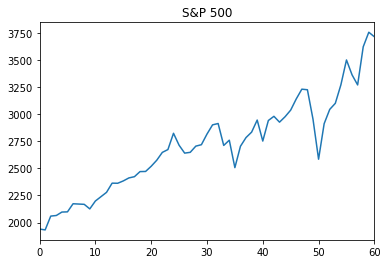

In [8]:
# download SP500 closing prices
# if you get an error after executing the code, try adding below.

!pip install pandas_datareader
import pandas_datareader.data as web
import pandas_datareader as pdr

import datetime

pd.set_option('display.float_format', lambda x: '%.6f' % x)

start = datetime.datetime(2016, 1, 1)
end = today

# pd.core.common.is_list_like = pd.api.types.is_list_like


# SP500 = web.DataReader(['sp500'], 'fred', start, end)
# display(SP500.head())

SP500 = pdr.get_data_fred('sp500', start, end)
SP500 = SP500.reset_index(level=SP500.index.names)
SP500['End_of_Month'] = SP500['DATE'] + pd.offsets.MonthEnd(0)
SP500 = SP500.sort_values('DATE').groupby('End_of_Month').last()

# SP500['Monthly_Return'] = (SP500['sp500']/ SP500['sp500'].shift(1)) -1
# SP500['sp500_1M_Previous'] = SP500['sp500'].shift(1)

SP500 = SP500.drop('DATE', axis=1)
SP500 = SP500.reset_index(level=SP500.index.names)

#Drop all Not a number values using drop method.
SP500.dropna(inplace = True)
print(' SP500: ')
display(get_df_name(SP500))
print(' DF Info: ')
display(SP500.info(verbose=True))
print(' SP500 Describe: ')
display(SP500.describe(include='all').transpose().head())
print(' SP500 Head: ')
display(SP500.head())
print(' SP500 Tail: ')
display(SP500.tail())
SP500['sp500'].plot(title='S&P 500')

In [9]:
# Data Preparation
# Rename Studio, filter studio and prep data

# set variales
target_column_name = 'Revenue'
time_column_name = 'Snapshot_Date_Short'
time_series_id_column_names = ['Relative_Offset','Sub_Region_Code']
sort_cols = ['Snapshot_Date_Short', 'End_of_Month', 'Sub_Region_Code']
sort_cols1 = ['End_of_Month', 'Sub_Region_Code']

exclude_sub_region = ['Singapore', 'NA']

pd.set_option('display.float_format', lambda x: '%.2f' % x)


# display(exclude_studio)

talenthist1 = talenthist.copy()
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()
talenthist1.columns = \
    talenthist1.columns.astype(str).str.replace('Contrib ', '')
pipehist1.columns = pipehist1.columns.astype(str).str.replace('Contrib '
        , '')
pipetrend1.columns = \
    pipetrend1.columns.astype(str).str.replace('Contrib ', '')
opphist1.columns = opphist1.columns.astype(str).str.replace('Managing '
        , '')
projhist1.columns = \
    projhist1.columns.astype(str).str.replace('Managing ', '')
revhist1.columns = revhist1.columns.astype(str).str.replace('Managing '
        , '')


pipetrend1.drop(columns='Snapshot Date Short', axis=1, inplace = True)
# talenthist1 = talenthist.rename(columns={'Contrib Studio Name': 'Studio'})
# pipehist1 = pipehist.rename(columns={'Contrib Studio Name': 'Studio'})

# revhist1 = revhist.rename(columns={'Managing Studio Name': 'Studio'})

#pipetrend1 = \
#    pipetrend1.rename(columns={'Snapshot End of Month': 'End of Month'})

                                       # 'Contrib Studio Name': 'Studio'})
# opphist1 = opphist.rename(columns={'Managing Studio Name': 'Studio'})
# projhist1 = projhist.rename(columns={'Managing Studio Name': 'Studio'})
# revhist1 = revhist1.query('End_of_Month < @current_eom').reset_index(drop=True)

display(pipetrend1)
cols_float1 = opphist1.filter(like='Rate', axis=1).columns
remove_percetage(opphist1, cols_float1)
cols_float2 = pipehist1.filter(like='Yield', axis=1).columns
remove_percetage(pipehist1, cols_float2)

talenthist1 = data_prep(talenthist1)
pipehist1 = data_prep(pipehist1)
revhist1 = data_prep(revhist1)
pipetrend1 = data_prep(pipetrend1)
opphist1 = data_prep(opphist1)
projhist1 = data_prep(projhist1)
#display(pipetrend1)
coerce_df_columns_to_numeric(talenthist1)
coerce_df_columns_to_numeric(revhist1)
coerce_df_columns_to_numeric(opphist1)
coerce_df_columns_to_numeric(projhist1)
coerce_df_columns_to_numeric(pipehist1)
coerce_df_columns_to_numeric(pipetrend1)
# display(pipetrend1)
# show_stats(pipehist1)

#revhist1 = revhist1.query('Sub_Region_Code not in @exclude_sub_region').copy()

pipehist1['Snapshot_Date_Short'] = pipehist1['Snapshot_Date_Short'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
pipehist1['End_of_Month'] = pipehist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
pipetrend1['End_of_Month'] = pipetrend1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
opphist1['End_of_Month'] = opphist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
projhist1['End_of_Month'] = projhist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
revhist1['End_of_Month'] = revhist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
talenthist1['End_of_Month'] = talenthist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)

# Sort

pipehist1.sort_values(by=sort_cols).reset_index(drop=True)
revhist1.sort_values(by=sort_cols1).reset_index(drop=True)
talenthist1.sort_values(by=sort_cols1).reset_index(drop=True)
pipetrend1.sort_values(by=sort_cols1).reset_index(drop=True)
opphist1.sort_values(by=sort_cols1).reset_index(drop=True)
projhist1.sort_values(by=sort_cols1).reset_index(drop=True)

display(talenthist1.tail())
display(pipehist1.tail())
display(revhist1.tail())
display(opphist1.tail())
display(projhist.tail())
display(pipetrend1.tail())

,End of Month,Sub Region Code,Pipeline Trend,Pipeline Trend Avg
0,2018-07-31,China,961327.99,320442.66
1,2018-07-31,Japan,2009968.24,669989.41
2,2018-07-31,North America,38549549.12,12849849.71
3,2018-07-31,Europe,3452914.01,1150971.34
4,2018-07-31,Academy,52275.71,17425.24
...,...,...,...,...
266,2021-01-31,Academy,0.00,0.00
267,2021-01-31,Centers of Excellence,2052960.56,684320.19
268,2021-01-31,Play Lab,494481.08,164827.03
269,2021-01-31,Global,1027643.35,342547.78


,End_of_Month,Sub_Region_Code,Headcount,Headcount_Contingent
526,2021-12-31,Europe,65,5
527,2021-12-31,Academy,18,0
528,2021-12-31,Centers of Excellence,22,0
529,2021-12-31,Play Lab,20,0
530,2021-12-31,Global,20,0


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
12824,2021-01-31,0,2021-12-31,11,North America,1015472,1218067,624227,465104,1798588
12825,2021-01-31,0,2021-12-31,11,Europe,276619,295356,141044,79177,324738
12826,2021-01-31,0,2021-12-31,11,Centers of Excellence,107683,114578,107683,107683,193057
12827,2021-01-31,0,2021-12-31,11,Play Lab,0,0,0,0,41647
12828,2021-01-31,0,2021-12-31,11,Global,21596,21270,21596,21596,36507


,End_of_Month,Sub_Region_Code,Revenue
390,2021-01-31,Global,3002
391,2021-02-28,Academy,1035947
392,2021-02-28,Play Lab,250000
393,2021-03-31,Academy,1005739
394,2021-03-31,Play Lab,50000


,End_of_Month,Sub_Region_Code,Current_Opp._Period_Value
225,2021-01-31,China,2041215
226,2021-01-31,Japan,718080
227,2021-01-31,North America,12528002
228,2021-01-31,Europe,2474660
229,2021-01-31,Play Lab,944000


,End of Month,Managing Sub Region Code,Conversions
304,2021-01-31,Japan,872160.00
305,2021-01-31,North America,12936536.00
306,2021-01-31,Europe,178294.50
307,2021-01-31,Centers of Excellence,351601.00
308,2021-01-31,Play Lab,47000.00


,End_of_Month,Sub_Region_Code,Pipeline_Trend,Pipeline_Trend_Avg
265,2021-01-31,Europe,5024684,1674894
266,2021-01-31,Academy,0,0
267,2021-01-31,Centers of Excellence,2052960,684320
268,2021-01-31,Play Lab,494481,164827
269,2021-01-31,Global,1027643,342547


In [10]:
display(pipehist1.query('Relative_Snapshot_Month_Offset == 0'))

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
12330,2021-01-31,0,2017-01-31,-48,China,639967,3257877,684915,744826,3257877
12331,2021-01-31,0,2017-01-31,-48,Japan,329393,2161373,353251,368499,2161373
12333,2021-01-31,0,2017-01-31,-48,North America,9428261,58284461,9705325,9699050,58284461
12334,2021-01-31,0,2017-01-31,-48,Europe,1155943,8450199,1225365,1226738,8450199
12335,2021-01-31,0,2017-01-31,-48,Academy,589253,1924815,495201,482252,1924815
...,...,...,...,...,...,...,...,...,...,...
12824,2021-01-31,0,2021-12-31,11,North America,1015472,1218067,624227,465104,1798588
12825,2021-01-31,0,2021-12-31,11,Europe,276619,295356,141044,79177,324738
12826,2021-01-31,0,2021-12-31,11,Centers of Excellence,107683,114578,107683,107683,193057
12827,2021-01-31,0,2021-12-31,11,Play Lab,0,0,0,0,41647


In [11]:
print(' revhist1: ')

# revhist1.to_csv('revhist1.csv', index=False)
# show_stats(revhist1)
# display(revhist1.query('Fin_Entity_ID==@entity_debug').reset_index(drop=True))
# pivot

revhist_pivot = revhist1.pivot_table(index=['End_of_Month','Sub_Region_Code'],
        values='Revenue', margins=False)  # columns = ['Fin_Entity_ID'],
                                          # aggfunc=['sum','count'],

# revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})

revhist_pivot = \
    revhist_pivot.reset_index()

# revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
# revhist_pivot.index.name = 'Date'

revhist_pivot.fillna(0, inplace=True)
revhist_pivot.tail(10)


 revhist1: 


,End_of_Month,Sub_Region_Code,Revenue
381,2020-12-31,Japan,1004057
382,2020-12-31,North America,8854120
383,2020-12-31,Play Lab,492145
384,2021-01-31,Academy,582564
385,2021-01-31,Global,3002
386,2021-01-31,Play Lab,1205643
387,2021-02-28,Academy,1035947
388,2021-02-28,Play Lab,250000
389,2021-03-31,Academy,1005739
390,2021-03-31,Play Lab,50000


In [12]:
# Cross join to get all unquie values of End_of_Month and Sub_Region_Code

d = pd.date_range(start_date, end_date, freq='m')
eom = pd.DataFrame(d, columns=['End_of_Month'])

# eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep='last').sort_values(by=['End_of_Month']).reset_index(drop=True)
sub_region_code = pd.DataFrame(talenthist1['Sub_Region_Code'].unique(), columns=['Sub_Region_Code'])
eom['key'] = 0
sub_region_code['key'] = 0
eom_region = pd.merge(eom, sub_region_code, on=['key'])
eom_region = eom_region.replace(np.nan, 'Unknown', regex=True)
eom_region.drop(columns=['key'], axis=1, inplace = True)

print(' EOM: ')

display(eom.info(verbose=True))
eom_region

 EOM: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
End_of_Month    60 non-null datetime64[ns]
key             60 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


None

,End_of_Month,Sub_Region_Code
0,2017-01-31,China
1,2017-01-31,Japan
2,2017-01-31,North America
3,2017-01-31,Europe
4,2017-01-31,Academy
...,...,...
475,2021-12-31,Europe
476,2021-12-31,Academy
477,2021-12-31,Centers of Excellence
478,2021-12-31,Play Lab


In [13]:
# Merge eom_studio with Revenue, Talent, Opportunity, Project

from functools import reduce
nan_value = 0
merge_dfs = [
    eom_region,
    revhist1,
    talenthist1,
    opphist1,
    projhist1,
    pipetrend1,
    ]

merge_df = reduce(lambda left, right: pd.merge(left, right, how='left',
                  on=['End_of_Month','Sub_Region_Code']), merge_dfs).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df)
merge_df = merge_df.replace(np.nan, 0, regex=True)

# merge_df = merge_df.query('Fin_Entity_ID!='SGP'') # Exclude Singapore rows

merge_df['Relative_Month_Offset'] = round((merge_df['End_of_Month']
        - current_eom) / np.timedelta64(1, 'M'), 0).astype(int)
merge_df['Billable_Headcount'] = merge_df['Headcount'] \
    + merge_df['Headcount_Contingent']
merge_df.sort_values(by=sort_cols1).reset_index(drop=True)

# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)

print(' merge_df: ')

# merge_df.to_csv(output_data_path + 'merge_df.csv', index=False)
# show_stats(merge_df)

merge_df  # .query('Fin_Entity_ID==@entity_debug')')

 merge_df: 


,End_of_Month,Sub_Region_Code,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount
0,2017-01-31,China,639967,26,0,0,434540,0,0,-48,26
1,2017-01-31,Japan,329393,18,0,0,0,0,0,-48,18
2,2017-01-31,North America,9428262,342,19,0,11981645,0,0,-48,361
3,2017-01-31,Europe,1155943,50,4,0,922408,0,0,-48,54
4,2017-01-31,Academy,589253,14,0,0,69626,0,0,-48,14
...,...,...,...,...,...,...,...,...,...,...,...
475,2021-12-31,Europe,0,65,5,0,0,0,0,11,70
476,2021-12-31,Academy,0,18,0,0,0,0,0,11,18
477,2021-12-31,Centers of Excellence,0,22,0,0,0,0,0,11,22
478,2021-12-31,Play Lab,0,20,0,0,0,0,0,11,20


In [14]:
# Merge with SP500

eom1 = eom.copy()  # pd.DataFrame(d, columns=['End_of_Month'])
sp500_df = pd.merge(eom1, SP500, how='left', on=['End_of_Month'])

# sp500_df = sp500_df.ffill(axis = 0)

sp500_df = sp500_df.sort_values(by=['End_of_Month'
                                ]).reset_index(drop=True)
display(sp500_df)
merge_df1 = pd.merge(merge_df, sp500_df, how='left', on=['End_of_Month'
                     ])
coerce_df_columns_to_numeric(merge_df1)
merge_df1.drop(columns=['Headcount', 'Headcount_Contingent'], axis=1,
               inplace=True) 
merge_df1 = merge_df1.sort_values(by=sort_cols1).reset_index(drop=True)
# merge_df1.to_csv(output_data_path + 'merge_df1.csv', index=False)
show_stats(merge_df1)

,End_of_Month,key,sp500
0,2017-01-31,0,2278.87
1,2017-02-28,0,2363.64
2,2017-03-31,0,2362.72
3,2017-04-30,0,2384.20
4,2017-05-31,0,2411.80
5,2017-06-30,0,2423.41
6,2017-07-31,0,2470.30
7,2017-08-31,0,2471.65
8,2017-09-30,0,2519.36
9,2017-10-31,0,2575.26


 DF Name: 


'merge_df1'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 11 columns):
End_of_Month                 480 non-null datetime64[ns]
Sub_Region_Code              480 non-null object
Revenue                      480 non-null int64
Current_Opp._Period_Value    480 non-null int64
Conversions                  480 non-null int64
Pipeline_Trend               480 non-null int64
Pipeline_Trend_Avg           480 non-null int64
Relative_Month_Offset        480 non-null int64
Billable_Headcount           480 non-null int64
key                          480 non-null int64
sp500                        392 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(8), object(1)
memory usage: 41.4+ KB


None

 DF Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,480,60,2017-11-30 00:00:00,8,2017-01-31,2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,480,8,Academy,60,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,480.00,NaN,NaN,NaN,NaT,NaT,1451594.29,2884630.56,0.00,102356.75,479450.00,959904.00,12137512.00
Current_Opp._Period_Value,480.00,NaN,NaN,NaN,NaT,NaT,2664372.55,8347691.40,0.00,0.00,0.00,1268742.25,108901726.00
Conversions,480.00,NaN,NaN,NaN,NaT,NaT,1276668.76,2960372.99,0.00,0.00,60719.00,771040.50,18709504.00


 DF Head: 


,End_of_Month,Sub_Region_Code,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,key,sp500
0,2017-01-31,Academy,589253,0,69626,0,0,-48,14,0,2278.87
1,2017-01-31,Centers of Excellence,317276,0,50000,0,0,-48,9,0,2278.87
2,2017-01-31,China,639967,0,434540,0,0,-48,26,0,2278.87
3,2017-01-31,Europe,1155943,0,922408,0,0,-48,54,0,2278.87
4,2017-01-31,Global,54366,0,47470,0,0,-48,16,0,2278.87


 DF Tail: 


,End_of_Month,Sub_Region_Code,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,key,sp500
475,2021-12-31,Europe,0,0,0,0,0,11,70,0,nan
476,2021-12-31,Global,0,0,0,0,0,11,20,0,nan
477,2021-12-31,Japan,0,0,0,0,0,11,36,0,nan
478,2021-12-31,North America,0,0,0,0,0,11,293,0,nan
479,2021-12-31,Play Lab,0,0,0,0,0,11,20,0,nan


 EOM Sum:


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,key,sp500
0,2017-01-31,12796336,0,13505689,0,0,-384,509,0,18230.96
1,2017-02-28,12476754,0,8659142,0,0,-376,509,0,18909.12
2,2017-03-31,14191126,0,12745281,0,0,-368,510,0,18901.76
3,2017-04-30,12449450,0,10701239,0,0,-360,504,0,19073.60
4,2017-05-31,13669409,0,6457961,0,0,-352,510,0,19294.40


 EOM Count: 


,End_of_Month,Sub_Region_Code,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,key,sp500
0,2017-01-31,8,8,8,8,8,8,8,8,8,8
1,2017-02-28,8,8,8,8,8,8,8,8,8,8
2,2017-03-31,8,8,8,8,8,8,8,8,8,8
3,2017-04-30,8,8,8,8,8,8,8,8,8,8
4,2017-05-31,8,8,8,8,8,8,8,8,8,8


In [15]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Calculate pipeline month offset for corresponding snapshot dates

n_test_periods = 4
rolling_pipeline_period = 4
relative_offset_periods = 11
pipehist_long = pipehist1.copy()

pipehist_long['Relative_Offset'] = pipehist_long['Relative_Month_Offset'
        ] - pipehist_long['Relative_Snapshot_Month_Offset']
pipehist_long = \
    pipehist_long.query('Relative_Offset >= -@relative_offset_periods and \
                        Relative_Offset < @rolling_pipeline_period and \
                        Snapshot_Date_Short < @end_date'
                        )
cols = 'Relative_Offset'
pipehist_long[cols] = pipehist_long[cols].apply(pd.to_numeric,
        errors='coerce')

# pipehist2 = pipehist2.query('Relative_Offset>=-11 and Relative_Offset<=0')
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].astype(str).str.zfill(2) + 'M Pipeline'
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].str.replace('0','+')
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].str.replace('++M Pipeline','+0M Pipeline')
# pipehist_long['Relative_Offset'] = 'Relative' + pipehist_long['Relative_Offset'].str.replace('0-','-0')

pipehist_long.sort_values(by=sort_cols).reset_index(drop=True)  # ,'Fin_Entity_ID'

print (' pipehist_long: ')

# pipehist_long.to_csv(output_data_path + 'pipehist_long.csv',
#                     index=False)
display(pipehist_long)  # .query('Fin_Entity_ID==@entity_debug'))
pipehist_long.info()

 pipehist_long: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset
63,2018-07-31,-30,2017-08-31,-41,China,730547,701119,612395,625170,752322,-11
64,2018-07-31,-30,2017-08-31,-41,Japan,442962,408862,464365,471270,396981,-11
66,2018-07-31,-30,2017-08-31,-41,North America,10096961,9509710,9681468,9665164,9734598,-11
67,2018-07-31,-30,2017-08-31,-41,Europe,1150868,1232152,1327478,1267044,1251953,-11
68,2018-07-31,-30,2017-08-31,-41,Academy,447221,478366,665024,650370,484260,-11
...,...,...,...,...,...,...,...,...,...,...,...
12756,2021-01-31,0,2021-04-30,3,Europe,1143718,1674894,1000556,677338,1802518,3
12757,2021-01-31,0,2021-04-30,3,Academy,0,1020843,0,0,801972,3
12758,2021-01-31,0,2021-04-30,3,Centers of Excellence,793228,684320,627497,449517,459743,3
12759,2021-01-31,0,2021-04-30,3,Play Lab,101923,264827,71089,59312,576871,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3720 entries, 63 to 12760
Data columns (total 11 columns):
Snapshot_Date_Short               3720 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    3720 non-null int64
End_of_Month                      3720 non-null datetime64[ns]
Relative_Month_Offset             3720 non-null int64
Sub_Region_Code                   3720 non-null object
Pipeline                          3720 non-null int64
Pipeline_3_Month_Rolling_Avg      3720 non-null int64
Pipeline_3M_Forward_Avg           3720 non-null int64
Pipeline_6M_Forward_Avg           3720 non-null int64
Pipeline_6M_Rolling_Avg           3720 non-null int64
Relative_Offset                   3720 non-null int64
dtypes: datetime64[ns](2), int64(8), object(1)
memory usage: 348.8+ KB


In [16]:
# Convert pipe history from long to wide to match month end grain

pipehist_wide = pipehist_long.pivot_table(index='Snapshot_Date_Short', columns='Relative_Offset',
        values=['Pipeline', 'Pipeline_3_Month_Rolling_Avg'],
        aggfunc={'Pipeline':np.sum , 'Pipeline_3_Month_Rolling_Avg':np.mean}, margins=False)  # ,'Fin_Entity_ID'
pipehist_wide = \
    pipehist_wide.reset_index(level=pipehist_wide.index.names).reset_index(drop=True)
cols = list(pipehist_wide.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipehist_wide)
pipehist_wide['Snapshot_Date_Short'] = \
    pd.to_datetime(pipehist_wide['Snapshot_Date_Short'])

# pipehist_wide.rename(columns={0:'Pipeline_3_Month_Rolling_Avg'}, inplace=True)

pipehist_wide = pipehist_wide.sort_values(by='Snapshot_Date_Short').reset_index(drop=True)

print(' pipehist_wide: ')

display(pipehist_wide.info())

# pipehist_wide.query('Fin_Entity_ID==@entity_debug')

pipehist_wide

 pipehist_wide: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 31 columns):
(Snapshot_Date_Short, )                31 non-null datetime64[ns]
(Pipeline, -11)                        31 non-null int64
(Pipeline, -10)                        31 non-null int64
(Pipeline, -9)                         31 non-null int64
(Pipeline, -8)                         31 non-null int64
(Pipeline, -7)                         31 non-null int64
(Pipeline, -6)                         31 non-null int64
(Pipeline, -5)                         31 non-null int64
(Pipeline, -4)                         31 non-null int64
(Pipeline, -3)                         31 non-null int64
(Pipeline, -2)                         31 non-null int64
(Pipeline, -1)                         31 non-null int64
(Pipeline, 0)                          31 non-null int64
(Pipeline, 1)                          31 non-null int64
(Pipeline, 2)                          31 non-null int64
(Pipeline, 3)   

None

Snapshot_Date_Short  Pipeline                                                                                                                                             Pipeline_3_Month_Rolling_Avg                                                                                                                              
Relative_Offset                           -11       -10        -9        -8        -7        -6        -5        -4        -3        -2        -1         0         1         2         3                          -11      -10       -9       -8       -7       -6       -5       -4       -3       -2       -1        0        1        2        3
0               2018-07-31           13644811  13257048  13700128  13429236  12003450  14688390  13055988  15149544  14597786  16502901  14816104  13046086  19060365  16240817  16378064  1616550                      1613092  1691749  1682767  1622642  1664862  1652996  1784083  1775746  1910890  1900419  1839472  1955106  2014469  2156107
1               2018-08-31           13257048  13700128  13429236  12003450  14688390  13055988  15149544  14597786  16502901  14816104  14385067  14014610  16891816  21721973  15793982  1613092                      1691749  1682767  1622642  1664862  1652996  1784083  1775746  1910890  1900419  1891556  1800657  1887145  2192850  2268512
2               2018-09-30           13700132  13429234  12003452  14688390  13055988  15149544  14597785  16502901  14816104  14385072  15827437  13525104  29841976  26499629  15495233  1691749                      1682767  1622643  1664861  1652996  1784083  1775746  1910890  1900419  1891556  1876192  1822400  2466438  2911113  3003042
3               2018-10-31           13429234  12003452  14688390  13055988  15149544  14597785  16502901  14816104  14385071  15827436  14759297  16301928  15885517  13170988  10173070  1682767                      1622643  1664861  1652996  1784083  1775746  1910890  1900419  1891556  1876192  1873825  1986898  1971656  1893152  1634565
4               2018-11-30           12003452  14688390  13055988  15149544  14597785  16502901  14816104  14385071  15827436  14759297  17699519  13677007  14060560  16270533  12916687  1622643                      1664861  1652996  1784083  1775746  1910890  1900419  1891556  1876192  1873825  2001260  1948010  1909789  1835807  1804127
5               2018-12-31           14688390  13055988  15149544  14597785  16502901  14816104  14384068  15827437  14759377  17699515  14995702  11534332  16802665  16818867  14970178  1664861                      1652996  1784083  1775746  1910890  1900419  1891514  1876150  1873786  2001263  1955604  1821967  1803982  1879947  2024654
6               2019-01-31           13055988  15149544  14597785  16502901  14816104  14384068  15827437  14759377  17699515  14995702  13193819  13445088  15577786  17810584  15681087  1652996                      1784083  1775746  1910890  1900419  1891514  1876150  1873786  2001263  1955604  1894655  1764437  1774431  1953451  2046829
7               2019-02-28           15149544  14597786  16502901  14816104  14384068  15827437  14759377  17699515  14995702  13193819  15784852  13596470  20275832  19934855  13562271  1784083                      1775746  1910890  1900419  1891514  1876150  1873786  2001263  1955604  1894655  1832265  1773964  2069047  2241965  2240540
8               2019-03-31           14597786  16502901  14816104  14384068  15827437  14759377  17699515  14995702  13193819  15644435  14976394  16087190  17363701  15824533  11591164  1775746                      1910890  1900419  1891514  1876150  1873786  2001263  1955604  1894655  1826414  1825299  1945856  2017493  2053142  1865808
9               2019-04-30           16502901  14816104  14384068  15827437  14759377  17699515  14995702  13193819  15644435  14982607  16782109  15500215  16723398  15378212  13076812  1910890                      1900419  1891514  1876150  1873786  2001263  1955

In [17]:
'''
# Merge merge_df with Pipeline Long History
# pipe_offset = ['Relative-00','Relative-01','Relative-02','Relative-03',
#               'Relative-04','Relative-05','Relative-06'
#               ,'Relative-07', 'Relative-08','Relative-09','Relative-10','Relative-11'
#              ]
# 1merge_final = pd.merge(merge_df1, pipehist_long.query('Relative_Offset == 0'), how='left', on=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'])
# 1merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code
'''

pipehist_long1 = pipehist_long.copy() 
merge_final = pd.merge(pipehist_long1, merge_df1, how='right',
                       on=['End_of_Month', 'Relative_Month_Offset', 'Sub_Region_Code'])
merge_final = merge_final.query('Relative_Snapshot_Month_Offset <= 0')
# merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code end

merge_final['End_of_Month'] = pd.to_datetime(merge_final['End_of_Month'
        ])
merge_final['Relative_Month_Offset'] = round((merge_final['End_of_Month'
        ] - current_eom) / np.timedelta64(1, 'M'), 0)
coerce_df_columns_to_numeric(merge_final)

merge_final['Relative_Offset'] = merge_final['Relative_Offset'
        ].apply(pd.to_numeric, errors='coerce').replace(np.nan, 0,
        regex=True).astype(int)
cond = ~merge_final['Snapshot_Date_Short'].isna()
merge_final['Snapshot_Date_Short'] = np.where(cond,
        merge_final['Snapshot_Date_Short'], merge_final['End_of_Month'])
merge_final['Relative_Snapshot_Month_Offset'] = \
    round((merge_final['Snapshot_Date_Short'] - current_eom)
          / np.timedelta64(1, 'M'), 0).astype(int)

# Filter for only next 11 months rows w.r.t. to snapshot date
# revpipe_final1 = revpipe_final.query('Relative_Offset in @pipe_offset').reset_index(drop=True)
# merge_final = merge_final.replace(np.nan, 0, regex=True)
coerce_df_columns_to_numeric(merge_final)
merge_final = merge_final.sort_values(by=sort_cols).reset_index(drop=True)
display(merge_final.info())
merge_final.rename(columns={
    -12: '-12M Pipeline',
    -11: '-11M Pipeline',
    -10: '-10M Pipeline',
    -9: '-9M Pipeline',
    -8: '-8M Pipeline',
    -7: '-7M Pipeline',
    -6: '-6M Pipeline',
    -5: '-5M Pipeline',
    -4: '-4M Pipeline',
    -3: '-3M Pipeline',
    -2: '-2M Pipeline',
    -1: '-1M Pipeline',
    0: '0M Pipeline',
    1: '1M Pipeline',
    2: '2M Pipeline',
    3: '3M Pipeline',
    4: '4M Pipeline',
    5: '5M Pipeline',
    6: '6M Pipeline',
    7: '7M Pipeline',
    8: '8M Pipeline',
    9: '9M Pipeline',
    10: '10M Pipeline',
    11: '11M Pipeline',
    }, inplace=True)

print(' merge_final: ')

merge_final.to_csv(output_data_path + 'merge_final.csv', index=False)
merge_final.to_parquet(output_data_path + 'merge_final.parquet',
                       index=None)
show_stats(merge_final)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 19 columns):
Snapshot_Date_Short               3720 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    3720 non-null int64
End_of_Month                      3720 non-null datetime64[ns]
Relative_Month_Offset             3720 non-null int64
Sub_Region_Code                   3720 non-null object
Pipeline                          3720 non-null int64
Pipeline_3_Month_Rolling_Avg      3720 non-null int64
Pipeline_3M_Forward_Avg           3720 non-null int64
Pipeline_6M_Forward_Avg           3720 non-null int64
Pipeline_6M_Rolling_Avg           3720 non-null int64
Relative_Offset                   3720 non-null int64
Revenue                           3720 non-null int64
Current_Opp._Period_Value         3720 non-null int64
Conversions                       3720 non-null int64
Pipeline_Trend                    3720 non-null int64
Pipeline_Trend_Avg                3720 non-null int64
Billable_H

None

 merge_final: 
 DF Name: 


'merge_final'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 19 columns):
Snapshot_Date_Short               3720 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    3720 non-null int64
End_of_Month                      3720 non-null datetime64[ns]
Relative_Month_Offset             3720 non-null int64
Sub_Region_Code                   3720 non-null object
Pipeline                          3720 non-null int64
Pipeline_3_Month_Rolling_Avg      3720 non-null int64
Pipeline_3M_Forward_Avg           3720 non-null int64
Pipeline_6M_Forward_Avg           3720 non-null int64
Pipeline_6M_Rolling_Avg           3720 non-null int64
Relative_Offset                   3720 non-null int64
Revenue                           3720 non-null int64
Current_Opp._Period_Value         3720 non-null int64
Conversions                       3720 non-null int64
Pipeline_Trend                    3720 non-null int64
Pipeline_Trend_Avg                3720 non-null int64

None

 DF Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,3720,31,2019-02-28 00:00:00,120,2018-07-31,2021-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,3720.00,NaN,NaN,NaN,NaT,NaT,-15.00,8.95,-30.00,-23.00,-15.00,-7.00,0.00
End_of_Month,3720,45,2020-01-31 00:00:00,120,2017-08-31,2021-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,3720.00,NaN,NaN,NaN,NaT,NaT,-19.00,9.93,-41.00,-27.00,-19.00,-11.00,3.00
Sub_Region_Code,3720,8,Play Lab,465,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 DF Head: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
0,2018-07-31,-30,2017-08-31,-41,Academy,447221,478366,665024,650370,484260,-11,447221,0,0,0,0,19,0,2471.65
1,2018-07-31,-30,2017-08-31,-41,Centers of Excellence,265949,263570,248755,263910,219088,-11,265949,0,0,0,0,12,0,2471.65
2,2018-07-31,-30,2017-08-31,-41,China,730547,701119,612395,625170,752322,-11,730547,0,0,0,0,25,0,2471.65
3,2018-07-31,-30,2017-08-31,-41,Europe,1150868,1232152,1327478,1267044,1251953,-11,1150868,0,2005673,0,0,53,0,2471.65
4,2018-07-31,-30,2017-08-31,-41,Global,215733,102216,142049,66858,136035,-11,215733,0,1000,0,0,14,0,2471.65


 DF Tail: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
3715,2021-01-31,0,2021-04-30,3,Europe,1143718,1674894,1000556,677338,1802518,3,0,0,0,0,0,70,0,nan
3716,2021-01-31,0,2021-04-30,3,Global,526391,342547,407178,229461,239061,3,0,0,0,0,0,22,0,nan
3717,2021-01-31,0,2021-04-30,3,Japan,794378,846124,511333,297960,855224,3,0,0,0,0,0,36,0,nan
3718,2021-01-31,0,2021-04-30,3,North America,7740852,8972593,5458777,3918943,8699754,3,0,0,0,0,0,306,0,nan
3719,2021-01-31,0,2021-04-30,3,Play Lab,101923,264827,71089,59312,576871,3,0,0,0,0,0,20,0,nan


 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
0,2017-08-31,-240,-328,13644811,12932407,13533996,13422278,13184535,-88,13644811,0,6762094,0,0,518,0,19773.20
1,2017-09-30,-472,-640,26514096,25809482,26924274,26613866,26057710,-168,26514096,0,9060342,0,0,1036,0,40309.76
2,2017-10-31,-696,-936,41100388,40601988,38943430,40825972,39711901,-240,41100384,0,20346957,0,0,1605,0,61806.24
3,2017-11-30,-912,-1216,53716940,53848552,53242256,55033064,52789096,-304,53716944,0,29632992,0,0,2172,0,84722.56
4,2017-12-31,-1120,-1480,60017256,64905718,65758650,71097123,64714710,-360,60017250,0,20854085,0,0,2640,0,106944.40


 EOM Count: 


,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
0,2017-08-31,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1,2017-09-30,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
2,2017-10-31,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
3,2017-11-30,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
4,2017-12-31,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40


 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
0,2018-07-31,-3600,-4080,219570718,215047658,213903845,198822982,210175607,-480,217515782,268772312,156913474,220221299,73407090,8311,0,323849.52
1,2018-08-31,-3480,-3960,224008023,218719783,215919808,199822900,212768635,-480,218866674,314793959,163336533,260698886,86899617,8397,0,326157.68
2,2018-09-30,-3360,-3840,243517981,237255209,236841078,222768516,223007167,-480,218803444,354651877,169755194,307316430,102438795,8471,0,326057.60
3,2018-10-31,-3240,-3720,214746705,216978037,204924268,187720128,214602161,-480,220747750,399393039,187839741,356781588,118927179,8539,0,327088.32
4,2018-11-30,-3120,-3600,220410274,219617675,215136476,200840078,217107375,-480,222301111,420210673,194250468,408442454,136147465,8603,0,328183.60


 SDS Count: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
0,2018-07-31,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
1,2018-08-31,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
2,2018-09-30,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
3,2018-10-31,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
4,2018-11-30,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120


In [18]:
# To distinguish the individual time-series, we define the time_series_id_column_names - the columns whose values determine the boundaries between time-series:

sort_list = [time_column_name] + list(set(time_series_id_column_names))
df = merge_final.copy()

In [19]:
# Data Split
# split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series.
# The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
# test_size = .11 #in percentage
# n_test_periods =  int(tseries * test_size)
# n_test_periods = rolling_pipeline_period

In [20]:
tseries = df.groupby(time_column_name).ngroups
display('Data contains {0} individual time_column_name.'.format(tseries))
test_size = round(n_test_periods / tseries, 2)
display('Test Size: ', test_size, 'Test Periods: ', n_test_periods)
display(df[time_column_name].unique())

'Data contains 31 individual time_column_name.'

'Test Size: '

0.13

'Test Periods: '

4

array(['2018-07-31T00:00:00.000000000', '2018-08-31T00:00:00.000000000',
       '2018-09-30T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000',
       '2019-01-31T00:00:00.000000000', '2019-02-28T00:00:00.000000000',
       '2019-03-31T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-05-31T00:00:00.000000000', '2019-06-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
       '2019-09-30T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
       '2019-11-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-02-29T00:00:00.000000000',
       '2020-03-31T00:00:00.000000000', '2020-04-30T00:00:00.000000000',
       '2020-05-31T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
       '2020-07-31T00:00:00.000000000', '2020-08-31T00:00:00.000000000',
       '2020-09-30T00:00:00.000000000', '2020-10-31

In [21]:
# df = merge_final.drop(columns=['End_of_Month','Relative_Month_Offset']).sort_values(by=sort_list)# axis=1, inplace = True)

nseries = df.groupby(time_series_id_column_names).ngroups
display('Data contains {0} individual time-series.'.format(nseries))
display(sort_list)
display(df['Relative_Offset'].unique())
display(df['End_of_Month'].unique())
display(df['Sub_Region_Code'].unique())

'Data contains 120 individual time-series.'

['Snapshot_Date_Short', 'Relative_Offset', 'Sub_Region_Code']

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3])

array(['2017-08-31T00:00:00.000000000', '2017-09-30T00:00:00.000000000',
       '2017-10-31T00:00:00.000000000', '2017-11-30T00:00:00.000000000',
       '2017-12-31T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
       '2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
       '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
       '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
       '2019-04-30T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
       '2019-06-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
       '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-10-31T00:00:00.000000000', '2019-11-30

array(['Academy', 'Centers of Excellence', 'China', 'Europe', 'Global',
       'Japan', 'North America', 'Play Lab'], dtype=object)

In [45]:
#train, test = split_full_for_forecasting(df=df, time_column_name=time_column_name, grain_column_names=time_series_id_column_names, test_split=test_size)

(train, test) = split_last_n_by_series_id(df, n_test_periods)



#train = df.query('Relative_Snapshot_Month_Offset <= -@n_test_periods')
#test = df.drop(train.index)
# test = merge_final1.query('(End_of_Month >= @current_eom)')#.sort_values(by=time_column_name)#.reset_index(drop=True)
# train = merge_final1.drop(test.index)#.sort_values(by=sort_list)#('(

display(df.shape)
display(train.shape)
display(test.shape)

# df1 = df.copy()
# train = df1.sample(frac=train_size, random_state=0)
# test = df1.drop(train.index)
# train_size = int(df.shape[0] * 0.9)
# train = df[:n_test_periods]
# test = df[n_test_periods:]

train.to_csv(output_data_path + r'./revforecast_train.csv', index=None,
             header=True)
test.to_csv(output_data_path + r'./revforecast_test.csv', index=None,
            header=True)
train.to_parquet(output_data_path + 'revforecast_train.parquet',
                       index=None)
test.to_parquet(output_data_path + 'revforecast_test.parquet',
                       index=None)
# train_file_path = 'train.csv'
# test_file_path = 'eval.csv'

(3720, 19)

(3240, 19)

(480, 19)

In [46]:
# Summary Stats for Train and Test dataframes

print ('Train************************')
display(train.info(verbose=True))
display(train.describe(include='all').transpose().head())
display(train)

Train************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3240 entries, 0 to 3239
Data columns (total 19 columns):
Snapshot_Date_Short               3240 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    3240 non-null int64
End_of_Month                      3240 non-null datetime64[ns]
Relative_Month_Offset             3240 non-null int64
Sub_Region_Code                   3240 non-null object
Pipeline                          3240 non-null int64
Pipeline_3_Month_Rolling_Avg      3240 non-null int64
Pipeline_3M_Forward_Avg           3240 non-null int64
Pipeline_6M_Forward_Avg           3240 non-null int64
Pipeline_6M_Rolling_Avg           3240 non-null int64
Relative_Offset                   3240 non-null int64
Revenue                           3240 non-null int64
Current_Opp._Period_Value         3240 non-null int64
Conversions                       3240 non-null int64
Pipeline_Trend                    3240 non-null int64
Pipeline_Trend_Avg                

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,3240,27,2019-02-28 00:00:00,120,2018-07-31,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,3240.0000,NaN,NaN,NaN,NaT,NaT,-17.0000,7.7901,-30.0000,-24.0000,-17.0000,-10.0000,-4.0000
End_of_Month,3240,41,2019-01-31 00:00:00,120,2017-08-31,2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,3240.0000,NaN,NaN,NaN,NaT,NaT,-21.0000,8.9083,-41.0000,-28.0000,-21.0000,-14.0000,-1.0000
Sub_Region_Code,3240,8,Play Lab,405,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
0,2018-07-31,-30,2017-08-31,-41,Academy,447221,478366,665024,650370,484260,-11,447221,0,0,0,0,19,0,2471.6500
120,2018-08-31,-29,2017-09-30,-40,Academy,589990,512552,746093,706318,490928,-11,589990,0,22500,0,0,19,0,2519.3600
240,2018-09-30,-28,2017-10-31,-39,Academy,957862,665024,769661,751822,576836,-11,957861,0,0,0,0,19,0,2575.2600
360,2018-10-31,-27,2017-11-30,-38,Academy,690428,746093,635716,666480,612230,-11,690429,0,0,0,0,21,0,2647.5800
480,2018-11-30,-26,2017-12-31,-37,Academy,660692,769661,666543,750285,641106,-11,660692,0,0,0,0,21,0,2673.6100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,2020-05-31,-8,2020-08-31,-5,Play Lab,195113,290794,383380,297708,305907,3,272923,299000,0,211033,70344,16,0,3500.3100
2879,2020-06-30,-7,2020-09-30,-4,Play Lab,75499,361499,379203,298689,347142,3,74877,852000,0,399275,133091,18,0,3363.0000
2999,2020-07-31,-6,2020-10-31,-3,Play Lab,750644,377201,363014,363014,399130,3,1492210,618420,851000,676405,225468,18,0,3269.9600
3119,2020-08-31,-5,2020-11-30,-2,Play Lab,316471,415475,152631,84883,419183,3,447396,450000,0,519217,173072,18,0,3621.6300


In [47]:
print ('Test************************')
display(test.info(verbose=True))
display(test.describe(include='all').transpose().head())
display(test)

Test************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 3240 to 3719
Data columns (total 19 columns):
Snapshot_Date_Short               480 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    480 non-null int64
End_of_Month                      480 non-null datetime64[ns]
Relative_Month_Offset             480 non-null int64
Sub_Region_Code                   480 non-null object
Pipeline                          480 non-null int64
Pipeline_3_Month_Rolling_Avg      480 non-null int64
Pipeline_3M_Forward_Avg           480 non-null int64
Pipeline_6M_Forward_Avg           480 non-null int64
Pipeline_6M_Rolling_Avg           480 non-null int64
Relative_Offset                   480 non-null int64
Revenue                           480 non-null int64
Current_Opp._Period_Value         480 non-null int64
Conversions                       480 non-null int64
Pipeline_Trend                    480 non-null int64
Pipeline_Trend_Avg                480 non-null i

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,480,4,2020-10-31 00:00:00,120,2020-10-31,2021-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,480.0000,NaN,NaN,NaN,NaT,NaT,-1.5000,1.1192,-3.0000,-2.2500,-1.5000,-0.7500,0.0000
End_of_Month,480,18,2020-04-30 00:00:00,32,2019-11-30,2021-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,480.0000,NaN,NaN,NaN,NaT,NaT,-5.5000,4.4675,-14.0000,-9.0000,-5.5000,-2.0000,3.0000
Sub_Region_Code,480,8,Academy,60,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
3240,2020-10-31,-3,2019-11-30,-14,Academy,912764,980795,767735,869435,895792,-11,912764,54000,0,1291372,430457,25,0,3140.9800
3360,2020-11-30,-2,2019-12-31,-13,Academy,789694,1015626,715665,873804,873788,-11,789694,84000,123900,418575,139525,25,0,3230.7800
3480,2020-12-31,-1,2020-01-31,-12,Academy,600747,767735,859909,912493,831827,-11,600747,228000,235944,356917,118972,24,0,3225.5200
3600,2021-01-31,0,2020-02-29,-11,Academy,756555,715665,971135,955772,848230,-11,756555,270100,100,368410,122803,24,0,2954.2200
3241,2020-10-31,-3,2019-11-30,-14,Centers of Excellence,223945,281523,156627,193684,274592,-11,223945,643000,440000,701725,233908,8,0,3140.9800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3718,2021-01-31,0,2021-04-30,3,North America,7740852,8972593,5458777,3918943,8699754,3,0,0,0,0,0,306,0,nan
3359,2020-10-31,-3,2021-01-31,0,Play Lab,209143,348223,87521,65966,480856,3,1205643,944000,47000,494481,164827,19,0,3714.2400
3479,2020-11-30,-2,2021-02-28,1,Play Lab,275169,540285,124625,96723,632525,3,250000,0,0,0,0,20,0,nan
3599,2020-12-31,-1,2021-03-31,2,Play Lab,122759,595206,51225,39585,702894,3,50000,0,0,0,0,20,0,nan


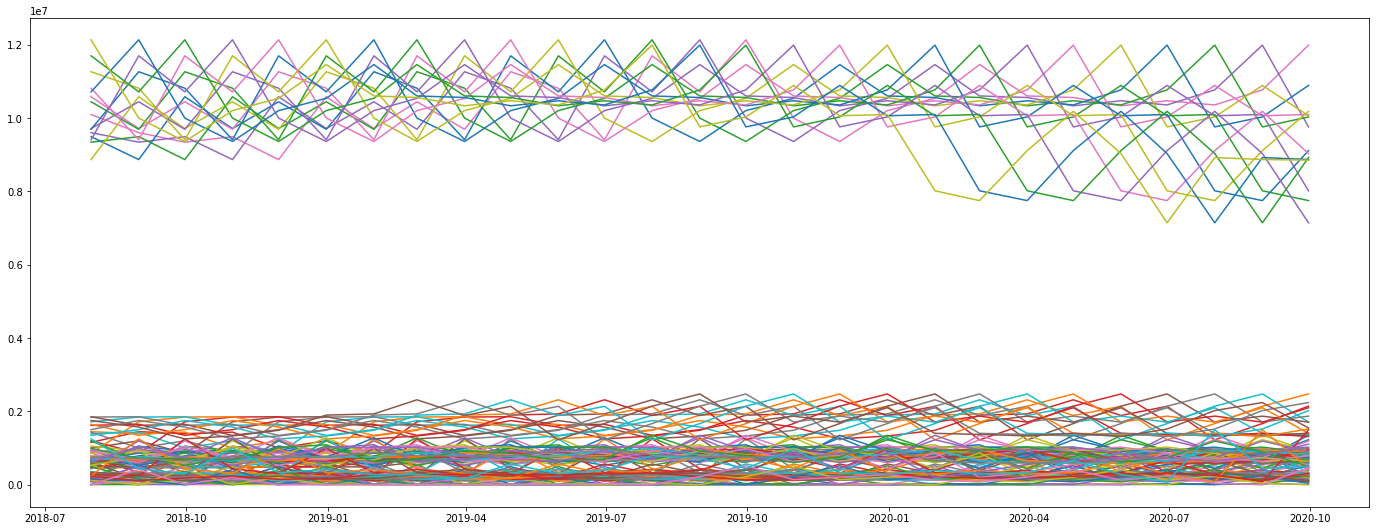

In [48]:
# plot the example time series
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# sns.set_context('paper', font_scale=1.3)
# sns.set_style('white')

(fig, ax) = plt.subplots(figsize=(24, 9))

whole_data = train.copy()
target_label = target_column_name
whole_data[target_label] = train[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
#plt.legend()
plt.show()

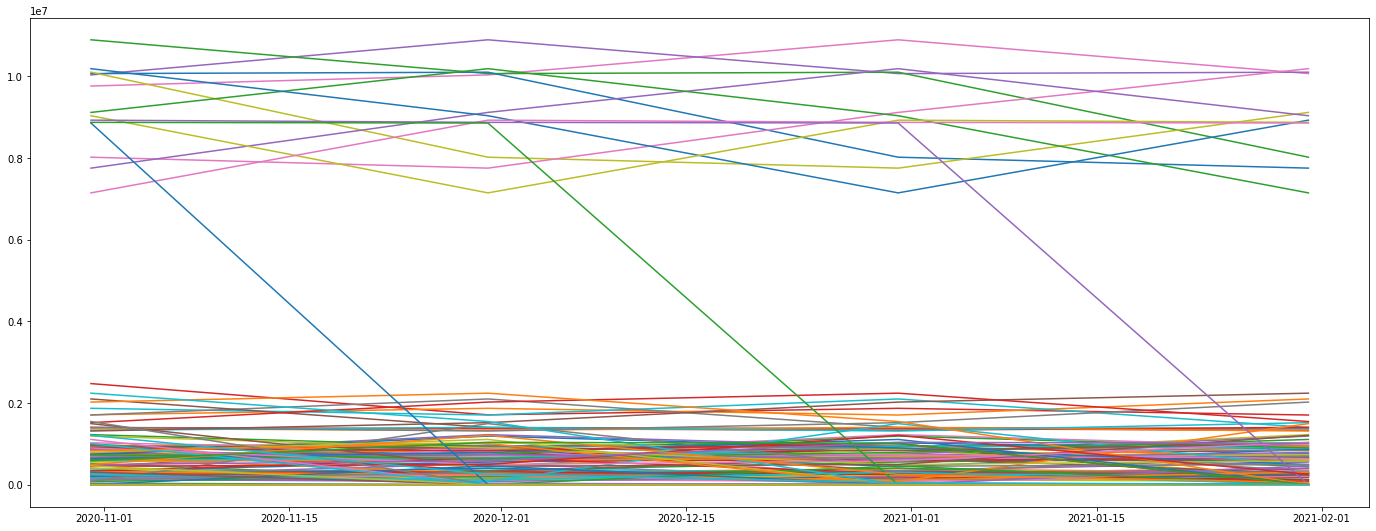

In [49]:
# plot the example time series
(fig, ax) = plt.subplots(figsize=(24, 9))
whole_data = test.copy()
target_label = target_column_name
whole_data[target_label] = test[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
#plt.legend()
plt.show()

In [77]:
datastore = ws.get_default_datastore()
datastore
datastore.upload_files(files=[output_data_path + 'revforecast_train.csv',
                       output_data_path + 'revforecast_test.csv'],
                       target_path='./revforecast/', overwrite=True,
                       show_progress=True)

Uploading an estimated of 2 files
Uploading ./outputs/revforecast_train.csv
Uploaded ./outputs/revforecast_train.csv, 1 files out of an estimated total of 2
Uploading ./outputs/revforecast_test.csv
Uploaded ./outputs/revforecast_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_d0f87d65818c45fa81f9990c2cdb633e

In [78]:
# Create dataset for training

from azureml.core.dataset import Dataset
train_dataset =Dataset.Tabular.from_delimited_files(path=datastore.path('revforecast/revforecast_train.csv'))

# train_dataset = Dataset.Tabular.from_parquet_files(path=datastore.path('./revforecast/revforecast_train.parquet'))


display(train_dataset.to_pandas_dataframe().head())
display(train_dataset.to_pandas_dataframe().tail())

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
0,2018-07-31,-30,2017-08-31,-41,Academy,447221,478366,665024,650370,484260,-11,447221,0,0,0,0,19,0,2471.6500
1,2018-08-31,-29,2017-09-30,-40,Academy,589990,512552,746093,706318,490928,-11,589990,0,22500,0,0,19,0,2519.3600
2,2018-09-30,-28,2017-10-31,-39,Academy,957862,665024,769661,751822,576836,-11,957861,0,0,0,0,19,0,2575.2600
3,2018-10-31,-27,2017-11-30,-38,Academy,690428,746093,635716,666480,612230,-11,690429,0,0,0,0,21,0,2647.5800
4,2018-11-30,-26,2017-12-31,-37,Academy,660692,769661,666543,750285,641106,-11,660692,0,0,0,0,21,0,2673.6100


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
3235,2020-05-31,-8,2020-08-31,-5,Play Lab,195113,290794,383380,297708,305907,3,272923,299000,0,211033,70344,16,0,3500.3100
3236,2020-06-30,-7,2020-09-30,-4,Play Lab,75499,361499,379203,298689,347142,3,74877,852000,0,399275,133091,18,0,3363.0000
3237,2020-07-31,-6,2020-10-31,-3,Play Lab,750644,377201,363014,363014,399130,3,1492210,618420,851000,676405,225468,18,0,3269.9600
3238,2020-08-31,-5,2020-11-30,-2,Play Lab,316471,415475,152631,84883,419183,3,447396,450000,0,519217,173072,18,0,3621.6300
3239,2020-09-30,-4,2020-12-31,-1,Play Lab,148787,516282,74651,57257,424962,3,492145,47000,375000,697455,232485,18,0,3756.0700


In [79]:
# Featurization Customization examples
'''
featurization_config = FeaturizationConfig()
featurization_config.drop_columns = ['Monthly_Return',
        'sp500_1M_Previous']

# Force the CPWVOL5 feature to be numeric type.
# featurization_config.add_column_purpose('CPWVOL5', 'Numeric')
# Fill missing values in the target column, Revenue, with zeros.

featurization_config.add_transformer_params('Imputer',
        [target_column_name], {'strategy': 'constant', 'fill_value': 0})

# Fill missing values in the Current Opp Period Value column with median value.

featurization_config.add_transformer_params('Imputer',
        ['Current_Opp._Period_Value'], {'strategy': 'median'})
featurization_config.add_transformer_params('Imputer', ['Conversions'],
        {'strategy': 'median'})

# Fill missing values in the sp500 column with forward fill (last value carried forward).

featurization_config.add_transformer_params('Imputer', ['sp500'],
        {'strategy': 'ffill'})
featurization_config.add_transformer_params('Imputer', ['Headcount'],
        {'strategy': 'ffill'})
featurization_config.add_transformer_params('Imputer',
        ['Headcount_Contingent'], {'strategy': 'ffill'})
'''

"\nfeaturization_config = FeaturizationConfig()\nfeaturization_config.drop_columns = ['Monthly_Return',\n        'sp500_1M_Previous']\n\n# Force the CPWVOL5 feature to be numeric type.\n# featurization_config.add_column_purpose('CPWVOL5', 'Numeric')\n# Fill missing values in the target column, Revenue, with zeros.\n\nfeaturization_config.add_transformer_params('Imputer',\n        [target_column_name], {'strategy': 'constant', 'fill_value': 0})\n\n# Fill missing values in the Current Opp Period Value column with median value.\n\nfeaturization_config.add_transformer_params('Imputer',\n        ['Current_Opp._Period_Value'], {'strategy': 'median'})\nfeaturization_config.add_transformer_params('Imputer', ['Conversions'],\n        {'strategy': 'median'})\n\n# Fill missing values in the sp500 column with forward fill (last value carried forward).\n\nfeaturization_config.add_transformer_params('Imputer', ['sp500'],\n        {'strategy': 'ffill'})\nfeaturization_config.add_transformer_params('I

In [80]:
# Train

from azureml.automl.core.forecasting_parameters import ForecastingParameters

lags = 'auto'  # [x for x in range(1,7)]
print ('lags: ', lags)
window_size = 'auto'
forecast_horizon = n_test_periods
print ('window_size: ', window_size, 
       ' forecast_horizon: ', forecast_horizon)
forecasting_parameters = ForecastingParameters(  # ,
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=lags,
    feature_lags='auto',
    target_rolling_window_size=window_size,
    )

    # drop_column_names = ['-1M Pipeline']

automl_config = AutoMLConfig(  # featurization_config,
    task='forecasting',
    debug_log='automl_revforecast_errors.log',
    primary_metric='normalized_root_mean_squared_error',
    experiment_timeout_hours=4,
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    featurization='auto',
    n_cross_validations=5,
    verbosity=logging.INFO,
    max_concurrent_iterations=4,
    max_cores_per_iteration=-1,
    enable_dnn=True,
    forecasting_parameters=forecasting_parameters,
    )

lags:  auto
window_size:  auto  forecast_horizon:  4


In [81]:
# submit a new training run
# '''
remote_run = experiment.submit(automl_config, show_output=True)
remote_run
# '''

Running on remote.
No run_configuration provided, running on compute-bi-ml-devqa01 with default configuration
Running on remote compute: compute-bi-ml-devqa01
Parent Run ID: AutoML_05cc3718-65e3-4122-ae72-c5def53c3b03

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.
Heuristic parameters: Target_Lag = '[1]', Target_Rolling_Window = '10'.


****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

*********************************************

Experiment,Id,Type,Status,Details Page,Docs Page
RevenueForecastRegion,AutoML_05cc3718-65e3-4122-ae72-c5def53c3b03,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [82]:
# If you need to retrieve a run that already started, use the following code
'''
from azureml.train.automl.run import AutoMLRun
remote_run = AutoMLRun(experiment=experiment,
                       run_id='AutoML_5d52a1b3-b85f-48c2-9298-1cd589b7640a'  #Run 939
                       )
'''                   

"\nfrom azureml.train.automl.run import AutoMLRun\nremote_run = AutoMLRun(experiment=experiment,\n                       run_id='AutoML_5d52a1b3-b85f-48c2-9298-1cd589b7640a'  #Run 939\n                       )\n"

In [83]:
remote_run.wait_for_completion()

{'runId': 'AutoML_05cc3718-65e3-4122-ae72-c5def53c3b03',
 'target': 'compute-bi-ml-devqa01',
 'status': 'Completed',
 'startTimeUtc': '2021-01-31T19:06:49.284854Z',
 'endTimeUtc': '2021-01-31T19:44:17.539663Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'compute-bi-ml-devqa01',
  'AMLSettingsJsonString': '{"path":null,"name":"RevenueForecastRegion","subscription_id":"db61fd47-db56-45e3-844f-1b1f5c47990a","resource_group":"rg-bi-automl-devqa01","workspace_name":"mlw-bi-automl-devqa01","region":"westus","compute_target":"compute-bi-ml-devqa01","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":

In [84]:
# Retrieve the Best Model

(best_run, fitted_model) = remote_run.get_output()
print ('Best Run Model: ', best_run)
print (fitted_model.steps)
model_name = best_run.properties['model_name']
print ('Model Name: ', model_name)

Best Run Model:  Run(Experiment: RevenueForecastRegion,
Id: AutoML_05cc3718-65e3-4122-ae72-c5def53c3b03_531,
Type: azureml.scriptrun,
Status: Completed)
[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
                      pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('StandardScalerWrapper', <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7f1514b969e8>), ('GradientBoostingRegressor', GradientBoostingRegressor(alpha=0.1, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.021544346900318822,
                          loss='ls', max_depth=5, max_features=0.8,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None,
                          min_samples_leaf=0.0074478228980205795,
                          min_samples_split=0.026024633095283807,
                          min_weight_fraction_leaf=0.0, n_estimators=60

In [85]:
# Transparency
# View updated featurization summary

featurization_summary = fitted_model.named_steps['timeseriestransformer'
        ].get_featurization_summary()

# View the featurization summary as a pandas dataframe

pd.DataFrame.from_records(featurization_summary)


,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Billable_Headcount,Numeric,No,9,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
1,Conversions,Numeric,No,9,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
2,Current_Opp._Period_Value,Numeric,No,9,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
3,End_of_Month,Numeric,No,10,"[MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer, MedianImputer-DateTimeTransformer]"
4,Pipeline,Numeric,No,23,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
5,Pipeline_3M_Forward_Avg,Numeric,No,9,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
6,Pipeline_3_Month_Rolling_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,Pipeline_6M_Forward_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,Pipeline_6M_Rolling_Avg,Numeric,No,9,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"
9,Pipeline_Trend,Numeric,No,16,"[MedianImputer, ImputationMarker, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag, MedianImputer-Lag]"


In [86]:
# Explore the results

from azureml.widgets import RunDetails
RunDetails(best_run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [87]:
# FORECASTING

X_test = test.copy()
y_test = X_test.pop(target_column_name).values

In [88]:
X_test.tail()

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
3718,2021-01-31,0,2021-04-30,3,North America,7740852,8972593,5458777,3918943,8699754,3,0,0,0,0,306,0,nan
3359,2020-10-31,-3,2021-01-31,0,Play Lab,209143,348223,87521,65966,480856,3,944000,47000,494481,164827,19,0,3714.24
3479,2020-11-30,-2,2021-02-28,1,Play Lab,275169,540285,124625,96723,632525,3,0,0,0,0,20,0,nan
3599,2020-12-31,-1,2021-03-31,2,Play Lab,122759,595206,51225,39585,702894,3,0,0,0,0,20,0,nan
3719,2021-01-31,0,2021-04-30,3,Play Lab,101923,264827,71089,59312,576871,3,0,0,0,0,20,0,nan


In [89]:
# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data

y_predictions, X_trans = fitted_model.forecast(X_test)

In [131]:
# from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test,
                       target_column_name)
df_all.tail(20)

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,origin,predicted,horizon_origin,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500,Revenue
460,2020-10-31,3,Europe,2020-09-30,1784793.3,1,-3,2021-01-31,0,1170975,1558005,956364,647795,1584248,2474660,178294,5024684,1674894,70,0,3714.2,0
461,2020-11-30,3,Europe,2020-09-30,1744350.6,2,-2,2021-02-28,1,1635285,1626915,1064649,825776,1772833,0,0,0,0,70,0,nan,0
462,2020-12-31,3,Europe,2020-09-30,1585080.3,3,-1,2021-03-31,2,1469498,1771787,1206455,918007,1837854,0,0,0,0,70,0,nan,0
463,2021-01-31,3,Europe,2020-09-30,1389577.5,4,0,2021-04-30,3,1143718,1674894,1000556,677338,1802518,0,0,0,0,70,0,nan,0
464,2020-10-31,3,Global,2020-09-30,171230.2,1,-3,2021-01-31,0,649560,578896,533812,299663,369583,0,0,1027643,342547,21,0,3714.2,3002
465,2020-11-30,3,Global,2020-09-30,275333.2,2,-2,2021-02-28,1,456103,456846,365119,365119,253297,0,0,0,0,21,0,nan,0
466,2020-12-31,3,Global,2020-09-30,347094.1,3,-1,2021-03-31,2,940964,774253,520993,288611,393511,0,0,0,0,22,0,nan,0
467,2021-01-31,3,Global,2020-09-30,225002.7,4,0,2021-04-30,3,526391,342547,407178,229461,239061,0,0,0,0,22,0,nan,0
468,2020-10-31,3,Japan,2020-09-30,805124.0,1,-3,2021-01-31,0,520230,566774,454980,272853,698825,718080,872160,2538374,846124,36,0,3714.2,0
469,2020-11-30,3,Japan,2020-09-30,655263.1,2,-2,2021-02-28,1,541685,534599,479046,267083,711874,0,0,0,0,36,0,nan,0


In [91]:
# Evaluate
# To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

# We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

# assign_dict = {'predicted': y_predictions, target_column_name: y_test}
# df_all = X_test.assign(**assign_dict)
# df_all

[Test data scores]
normalized_median_absolute_error:   0.002
explained_variance:   0.801
r2_score:   0.792
mean_absolute_percentage_error:   65.322
root_mean_squared_error:   1215285.811
root_mean_squared_log_error:   4.884
mean_absolute_error:   290564.953
spearman_correlation:   0.729
normalized_root_mean_squared_error:   0.112
normalized_mean_absolute_error:   0.027
normalized_root_mean_squared_log_error:   0.301
median_absolute_error:   23184.333


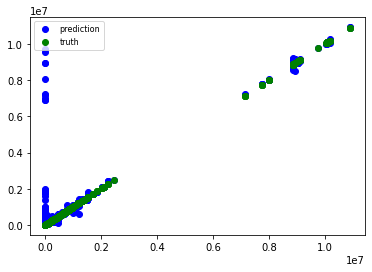

In [92]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module

scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print('[Test data scores]')
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs

%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
df_all.groupby('horizon_origin').apply(lambda df: \
        pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted'
        ]), 'RMSE': np.sqrt(mean_squared_error(df[target_column_name],
        df['predicted'])),
        'MAE': mean_absolute_error(df[target_column_name],
        df['predicted'])}))

,MAPE,RMSE,MAE
horizon_origin,,,
1,58.61,844484.19,152723.15
2,84.34,1128199.76,242034.39
3,69.67,1309574.89,330454.83
4,46.90,1485497.82,437047.44


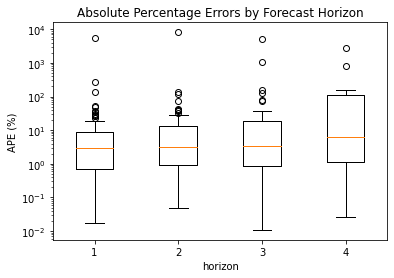

In [96]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name], df_all['predicted']))
APEs = [df_all_APE[df_all['horizon_origin'] == h].APE.values for h in range(1, forecast_horizon + 1)]

%matplotlib inline
plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE (%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')

plt.show()

In [97]:
# Confidence intervals

quantiles =  fitted_model.forecast_quantiles(X_test)
quantiles

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,0.5
0,2020-10-31,-11,Academy,920843.38
1,2020-11-30,-11,Academy,788411.09
2,2020-12-31,-11,Academy,604792.31
3,2021-01-31,-11,Academy,752615.66
4,2020-10-31,-11,Centers of Excellence,230874.13
...,...,...,...,...
475,2021-01-31,3,North America,6880653.96
476,2020-10-31,3,Play Lab,576762.44
477,2020-11-30,3,Play Lab,434593.31
478,2020-12-31,3,Play Lab,570126.65


In [98]:
# specify which quantiles you would like 

fitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]

# use forecast_quantiles function, not the forecast() one

y_pred_quantiles =  fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns 

y_pred_quantiles

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,0.01,0.5,0.8,0.95
0,2020-10-31,-11,Academy,419188.64,920843.38,1102330.97,1275540.38
1,2020-11-30,-11,Academy,286157.98,788411.09,970115.16,1143531.17
2,2020-12-31,-11,Academy,34928.58,604792.31,810956.40,1007716.75
3,2021-01-31,-11,Academy,170662.71,752615.66,963153.37,1164087.83
4,2020-10-31,-11,Centers of Excellence,-270780.61,230874.13,412361.72,585571.13
...,...,...,...,...,...,...,...
475,2021-01-31,3,North America,6298701.01,6880653.96,7091191.67,7292126.13
476,2020-10-31,3,Play Lab,75107.70,576762.44,758250.03,931459.44
477,2020-11-30,3,Play Lab,-67659.79,434593.31,616297.39,789713.40
478,2020-12-31,3,Play Lab,262.92,570126.65,776290.75,973051.10


In [133]:
# Get the column index list in the right order

cols_sort_list = list(df_all.columns) + ['Revenue_Forecast']
display(cols_sort_list)
display(df_all.head())
display(train.head())

['Snapshot_Date_Short',
 'Relative_Offset',
 'Sub_Region_Code',
 'origin',
 'predicted',
 'horizon_origin',
 'Relative_Snapshot_Month_Offset',
 'End_of_Month',
 'Relative_Month_Offset',
 'Pipeline',
 'Pipeline_3_Month_Rolling_Avg',
 'Pipeline_3M_Forward_Avg',
 'Pipeline_6M_Forward_Avg',
 'Pipeline_6M_Rolling_Avg',
 'Current_Opp._Period_Value',
 'Conversions',
 'Pipeline_Trend',
 'Pipeline_Trend_Avg',
 'Billable_Headcount',
 'key',
 'sp500',
 'Revenue',
 'Revenue_Forecast']

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,origin,predicted,horizon_origin,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500,Revenue
0,2020-10-31,-11,Academy,2020-09-30,920843.4,1,-3,2019-11-30,-14,912764,980795,767735,869435,895792,54000,0,1291372,430457,25,0,3141.0,912764
1,2020-11-30,-11,Academy,2020-09-30,788411.1,2,-2,2019-12-31,-13,789694,1015626,715665,873804,873788,84000,123900,418575,139525,25,0,3230.8,789694
2,2020-12-31,-11,Academy,2020-09-30,604792.3,3,-1,2020-01-31,-12,600747,767735,859909,912493,831827,228000,235944,356917,118972,24,0,3225.5,600747
3,2021-01-31,-11,Academy,2020-09-30,752615.7,4,0,2020-02-29,-11,756555,715665,971135,955772,848230,270100,100,368410,122803,24,0,2954.2,756555
4,2020-10-31,-11,Centers of Excellence,2020-09-30,230874.1,1,-3,2019-11-30,-14,223945,281523,156627,193684,274592,643000,440000,701725,233908,8,0,3141.0,223945


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500
0,2018-07-31,-30,2017-08-31,-41,Academy,447221,478366,665024,650370,484260,-11,447221,0,0,0,0,19,0,2471.7
120,2018-08-31,-29,2017-09-30,-40,Academy,589990,512552,746093,706318,490928,-11,589990,0,22500,0,0,19,0,2519.4
240,2018-09-30,-28,2017-10-31,-39,Academy,957862,665024,769661,751822,576836,-11,957861,0,0,0,0,19,0,2575.3
360,2018-10-31,-27,2017-11-30,-38,Academy,690428,746093,635716,666480,612230,-11,690429,0,0,0,0,21,0,2647.6
480,2018-11-30,-26,2017-12-31,-37,Academy,660692,769661,666543,750285,641106,-11,660692,0,0,0,0,21,0,2673.6


In [134]:
# Merge df_all with train

from functools import reduce

#train = train[list(df_all.columns)]

nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all,
                              ignore_index=True).sort_values(by=sort_cols)
coerce_df_columns_to_numeric(final_merge_df)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)

# merge_df = merge_df.query('Fin_Entity_ID!='SGP'') # Exclude Singapore rows
# final_merge_df.sort_values(by=['Relative_Offset','Fin_Entity_ID']).reset_index(drop=True) and Relative_Month_Offset >= 0
# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
# create new column

final_merge_df['Revenue_Forecast'] = np.where(final_merge_df['predicted'
        ] != 0, final_merge_df['predicted'], final_merge_df['Revenue'])
final_merge_df['Relative_Month_Offset'] = \
    round((final_merge_df['End_of_Month'] - current_eom)
          / np.timedelta64(1, 'M'), 0).astype(int)
final_merge_df['End_of_Month'] = \
    pd.to_datetime(final_merge_df['End_of_Month']).dt.date
final_merge_df['origin'] = pd.to_datetime(final_merge_df['origin'
        ]).dt.date

final_merge_df['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df['Snapshot_Date_Short'])
# sort using original cols_sort_list
final_merge_df = \
    final_merge_df.sort_values(by=sort_cols).reset_index(drop=True)
final_merge_df = final_merge_df.reindex(columns=cols_sort_list)

# add revenue vs predicted variance
final_merge_df['Diff'] = final_merge_df['Revenue'] - final_merge_df['predicted']
final_merge_df['Diff%'] = round(final_merge_df['Diff'] / final_merge_df['predicted'] * 100, ndigits=4)

print(' final_merge_df: ')

final_merge_df.to_csv(output_data_path + 'final_merge_df.csv',
                      index=False)
final_merge_df.to_parquet(output_data_path + 'final_merge_df.parquet',
                          index=None)
#show_stats(final_merge_df)
display(final_merge_df)
#final_merge_df  # .query('Fin_Entity_ID==@entity_debug')

 final_merge_df: 


,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,origin,predicted,horizon_origin,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,key,sp500,Revenue,Revenue_Forecast,Diff,Diff%
0,2018-07-31,-11,Academy,1970-01-01,0,0,-30,2017-08-31,-41,447221,478366,665024,650370,484260,0,0,0,0,19,0,2471.7,447221,447221,447221,inf
1,2018-07-31,-11,Centers of Excellence,1970-01-01,0,0,-30,2017-08-31,-41,265949,263570,248755,263910,219088,0,0,0,0,12,0,2471.7,265949,265949,265949,inf
2,2018-07-31,-11,China,1970-01-01,0,0,-30,2017-08-31,-41,730547,701119,612395,625170,752322,0,0,0,0,25,0,2471.7,730547,730547,730547,inf
3,2018-07-31,-11,Europe,1970-01-01,0,0,-30,2017-08-31,-41,1150868,1232152,1327478,1267044,1251953,0,2005673,0,0,53,0,2471.7,1150868,1150868,1150868,inf
4,2018-07-31,-11,Global,1970-01-01,0,0,-30,2017-08-31,-41,215733,102216,142049,66858,136035,0,1000,0,0,14,0,2471.7,215733,215733,215733,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715,2021-01-31,3,Europe,2020-09-30,1389577,4,0,2021-04-30,3,1143718,1674894,1000556,677338,1802518,0,0,0,0,70,0,0.0,0,1389577,-1389577,-100.0
3716,2021-01-31,3,Global,2020-09-30,225002,4,0,2021-04-30,3,526391,342547,407178,229461,239061,0,0,0,0,22,0,0.0,0,225002,-225002,-100.0
3717,2021-01-31,3,Japan,2020-09-30,861170,4,0,2021-04-30,3,794378,846124,511333,297960,855224,0,0,0,0,36,0,0.0,0,861170,-861170,-100.0
3718,2021-01-31,3,North America,2020-09-30,6880653,4,0,2021-04-30,3,7740852,8972593,5458777,3918943,8699754,0,0,0,0,306,0,0.0,0,6880653,-6880653,-100.0


In [104]:
# pivot by EOM1, Fin_Entity_ID
pd.set_option('display.float_format', lambda x: '%.1f' % x) #


cols = ['Pipeline','Revenue','predicted','Diff','Diff%']
final_merge_pivot1 = final_merge_df.query('Relative_Offset >= -3 and Relative_Snapshot_Month_Offset >= -3').pivot_table(index=['Snapshot_Date_Short','End_of_Month','Sub_Region_Code'], #columns='Relative_Offset',
        values=cols, aggfunc={'predicted':np.sum,'Pipeline':np.sum,'Revenue':np.sum,'Diff':np.sum, 'Diff%':np.mean}, margins=None)
#final_merge_pivot1 = \
#    final_merge_pivot1['End_of_Month'] = pd.to_datetime(final_merge_pivot1['End_of_Month']).dt.date
# final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)

# show_stats(revtime_pivot1)
final_merge_pivot1.sort_values(by=sort_cols,inplace=True)
#reorder columns
cols_order = [2,3,4,0,1]
final_merge_pivot1 = final_merge_pivot1[[final_merge_pivot1.columns[i] for i in cols_order]]

# set ALL float columns to '${:,.2f}' formatting (including the percentage)
#format_dict = {col_name: '${:,.1f}' for col_name in final_merge_pivot1.select_dtypes(float).columns}
# override the percentage column
format_dict = {col_name: '{:,}' for col_name in final_merge_pivot1.columns}
format_dict['Diff%'] = '{:.2f}'


# Format with commas and round off to two decimal places in pandas 
# final_merge_pivot1 = final_merge_pivot1[[['Snapshot_Date_Short','End_of_Month']+cols]]
final_merge_pivot1.tail(56).style.format(format_dict)#.style.format('{:,}')# .query('(End_of_Month == @current_eom)')

In [105]:
!pip install xlsxwriter
import xlsxwriter
final_merge_pivot1.tail(56).to_excel(output_data_path + r'./revenue_region_forecast.xlsx', \
             sheet_name=str(today.date()), header=True, engine='xlsxwriter')  

     |████████████████████████████████| 144 kB 22.3 MB/s eta 0:00:01


In [106]:
# multiple line plot
# Set themes

import matplotlib.pyplot as plt

# plot

sns.set()
sns.set_context('poster')  # In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style='whitegrid')  # Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks.

# Save a palette to a variable:

palette = sns.color_palette('Accent', 8)

# Use palplot and pass in the variable:
# sns.palplot(palette)
# Set the palette using the name of a palette:
# sns.set_palette(palette)

KeyError: 'Relative_Offset'

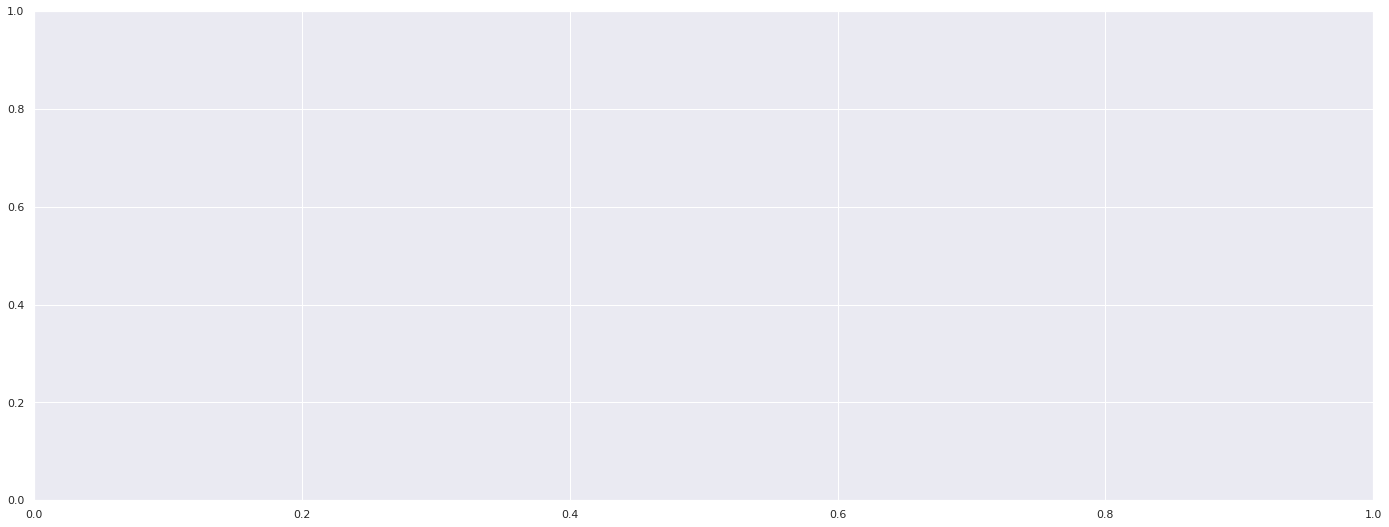

In [145]:
# Bar plot for history and forecast revenues summary by month

(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000

final_merge_df1 = final_merge_df.query('Relative_Offset >= -3 and Relative_Snapshot_Month_Offset >= -3').pivot_table(index=['Snapshot_Date_Short','End_of_Month','Sub_Region_Code'],
        values=cols, aggfunc={'predicted':np.sum,'Pipeline':np.sum,'Revenue':np.sum, 'Diff':np.sum, 'Diff%':np.mean}, margins=None)
final_merge_df1 = final_merge_df1.reset_index()

#final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset == 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
# final_merge_df1['Revenue_Forecast'] = \
#     round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='predicted',
    ci=None,
    data=final_merge_df1,
    palette=clrs,
    ax=ax,
    )
plt.xticks(rotation=90)
plt.title('Revenue & Forecast by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.1f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
g.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

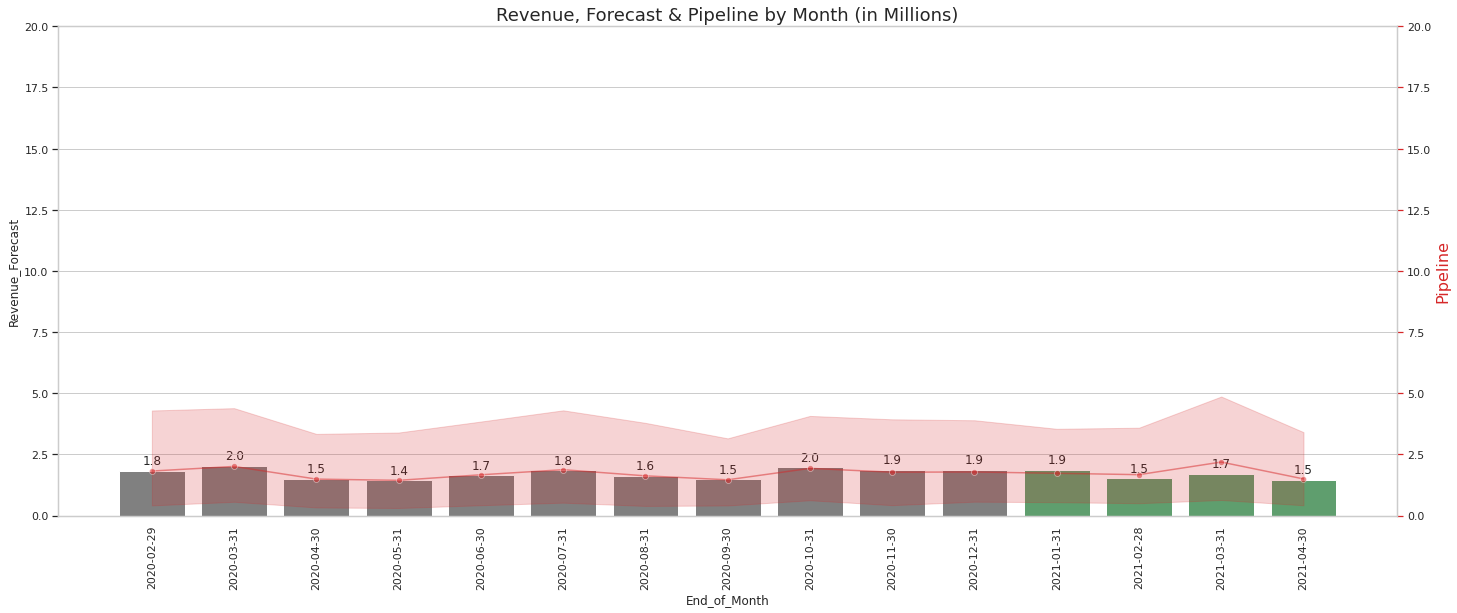

In [108]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset == 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='Revenue_Forecast',
    ci=None,
    data=final_merge_df1,
    palette=clrs,
    ax=ax1,
    )
plt.xticks(rotation=90)
plt.ylim(0,20)
plt.title('Revenue, Forecast & Pipeline by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.1f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Pipeline', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Pipeline',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
plt.ylim(0,20)
plt.show()

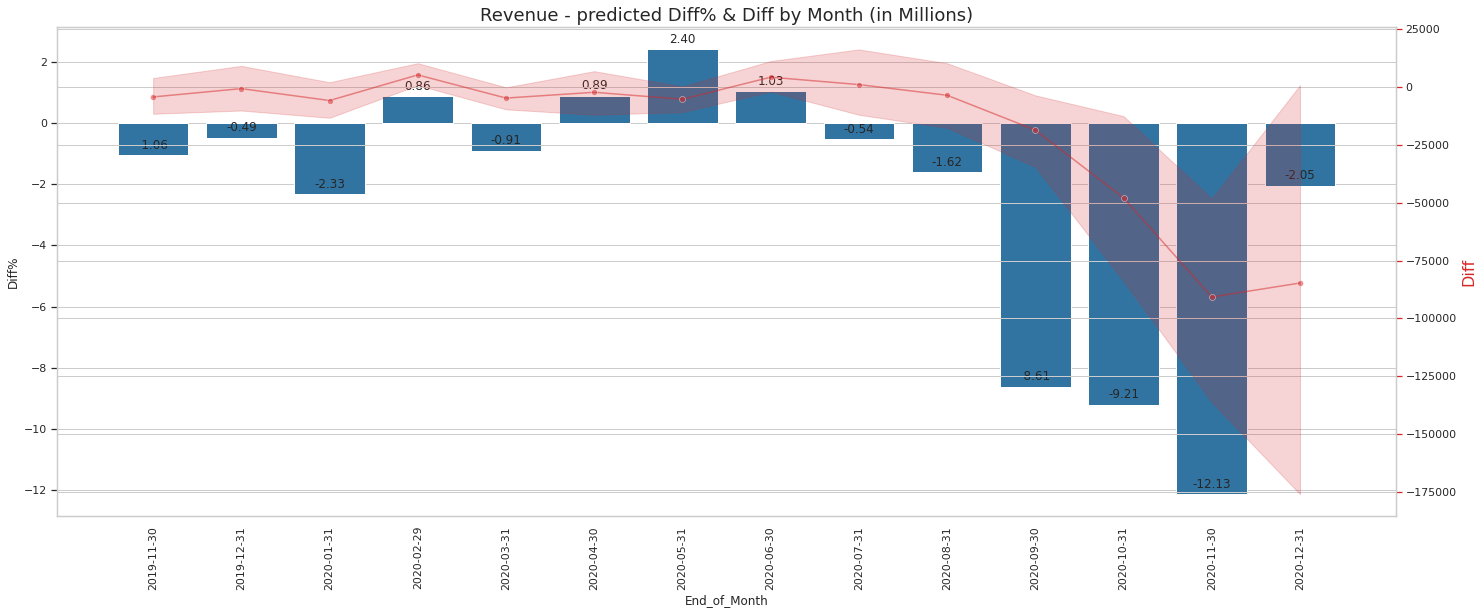

In [109]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset < 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='Diff%',
    ci=None,
    data=final_merge_df1,
    color='tab:blue',
    ax=ax1,
    )
plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Revenue - predicted Diff% & Diff by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.2f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Diff',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
plt.show()

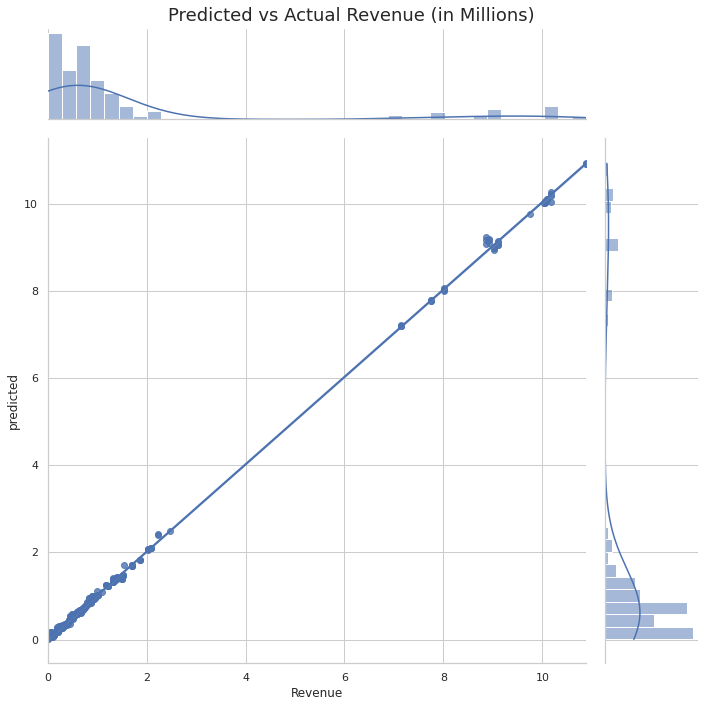

In [110]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset<0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.jointplot(  
    data=final_merge_df1,
    x='Revenue',
    y='predicted',
    #hue='Snapshot_Date_Short',
    kind='reg',
    height=10
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.suptitle('Predicted vs Actual Revenue (in Millions)', size=18)
plt.subplots_adjust( top = 0.95 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Diff',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot


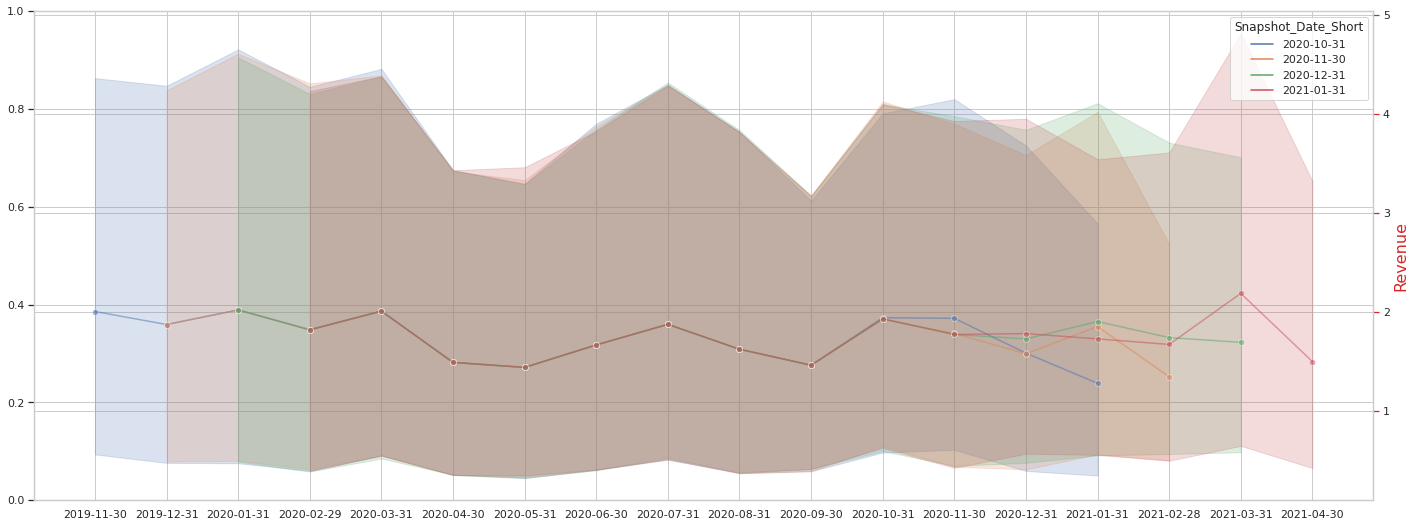

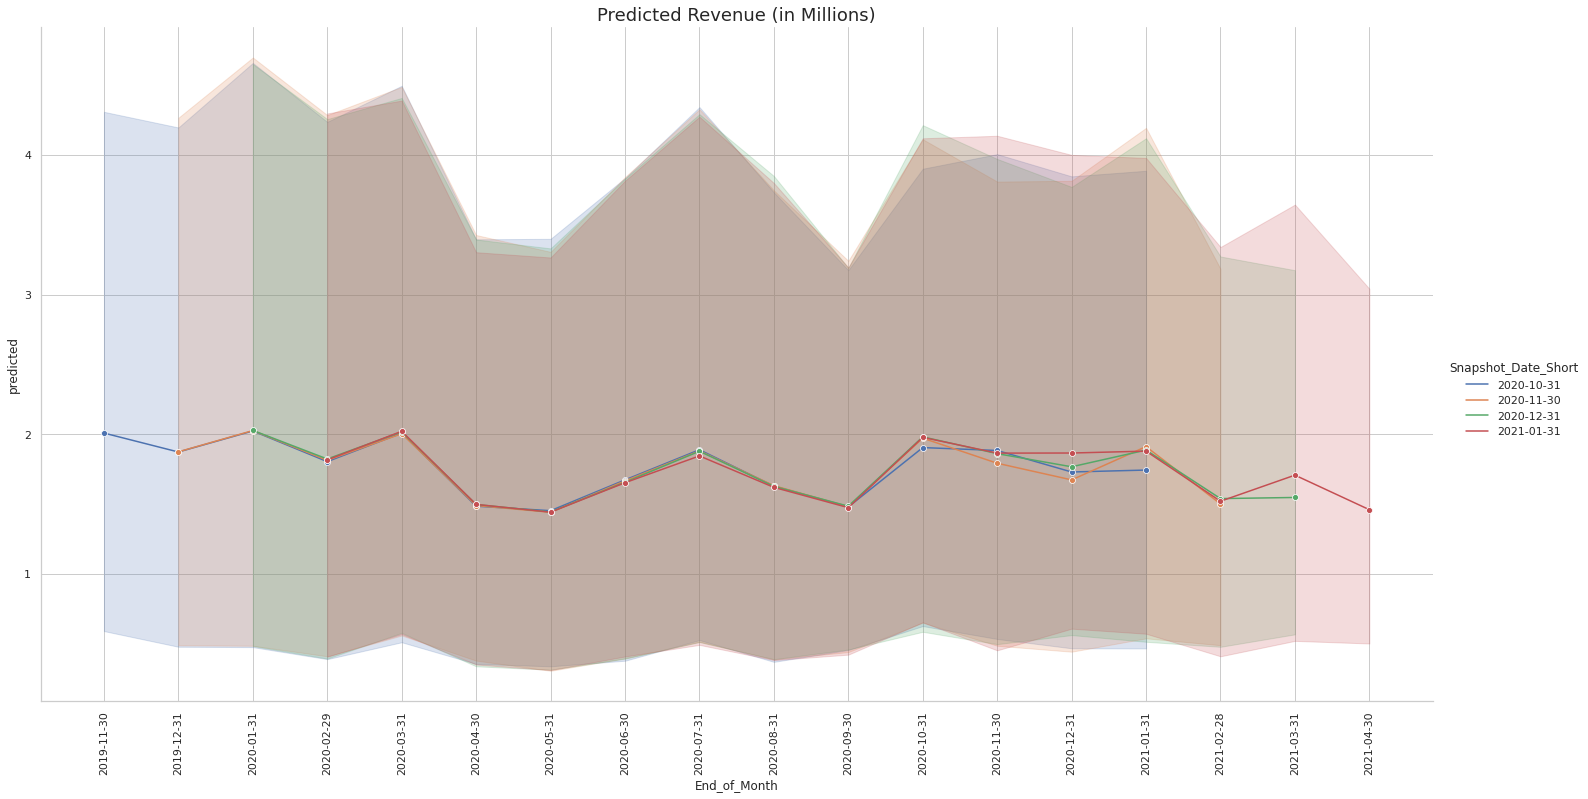

In [111]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.relplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='line',
    marker='o',
    height=10,
    aspect=2,
    ax=ax1
    )
plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
# '''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Revenue', fontsize=16, color=color)
g = sns.lineplot(
    data=final_merge_df1,
    x='End_of_Month',
    y='Pipeline',
    hue='Snapshot_Date_Short',
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
# '''
plt.show()

catplot is a figure-level function and does not accept target axes. You may wish to try barplot


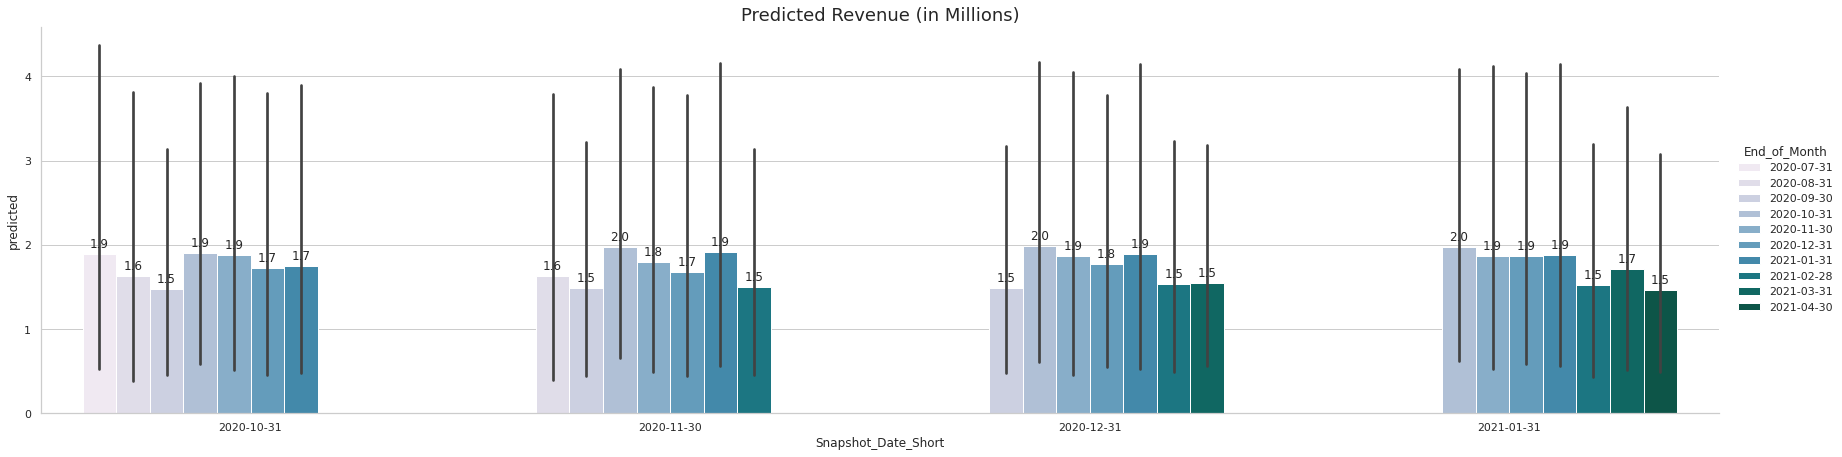

In [112]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='Snapshot_Date_Short',
    y='predicted',
    hue='End_of_Month',
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

catplot is a figure-level function and does not accept target axes. You may wish to try barplot


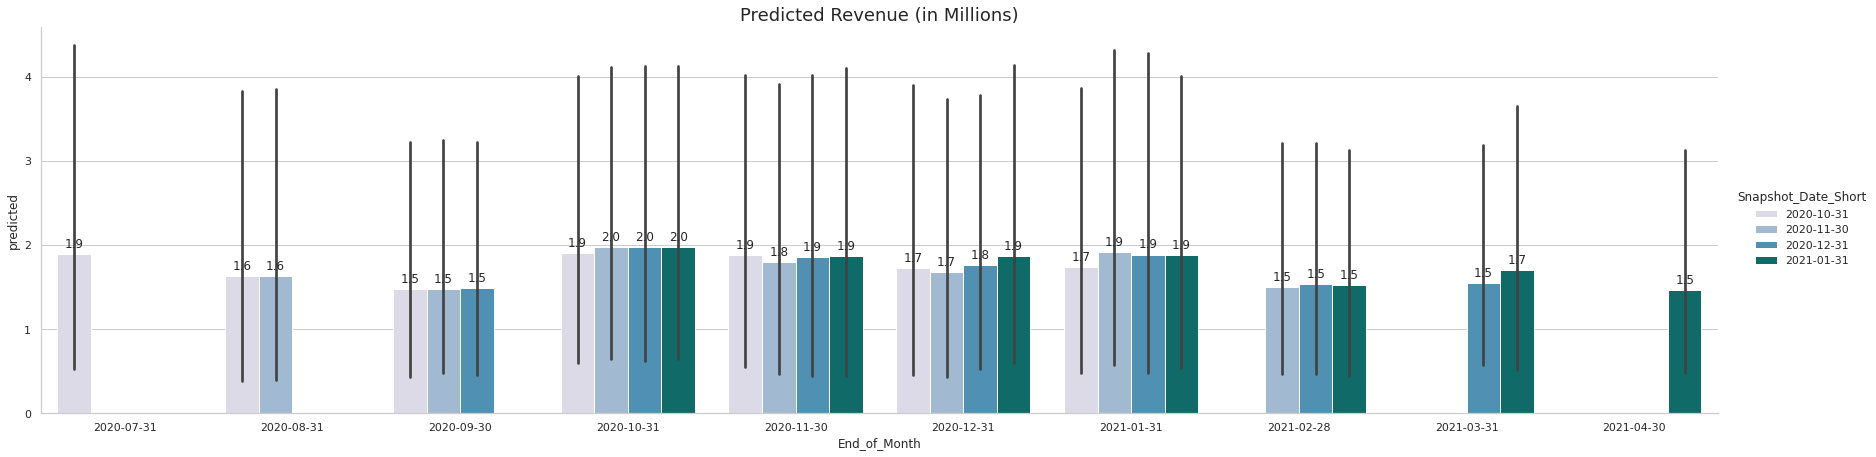

In [113]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

catplot is a figure-level function and does not accept target axes. You may wish to try barplot


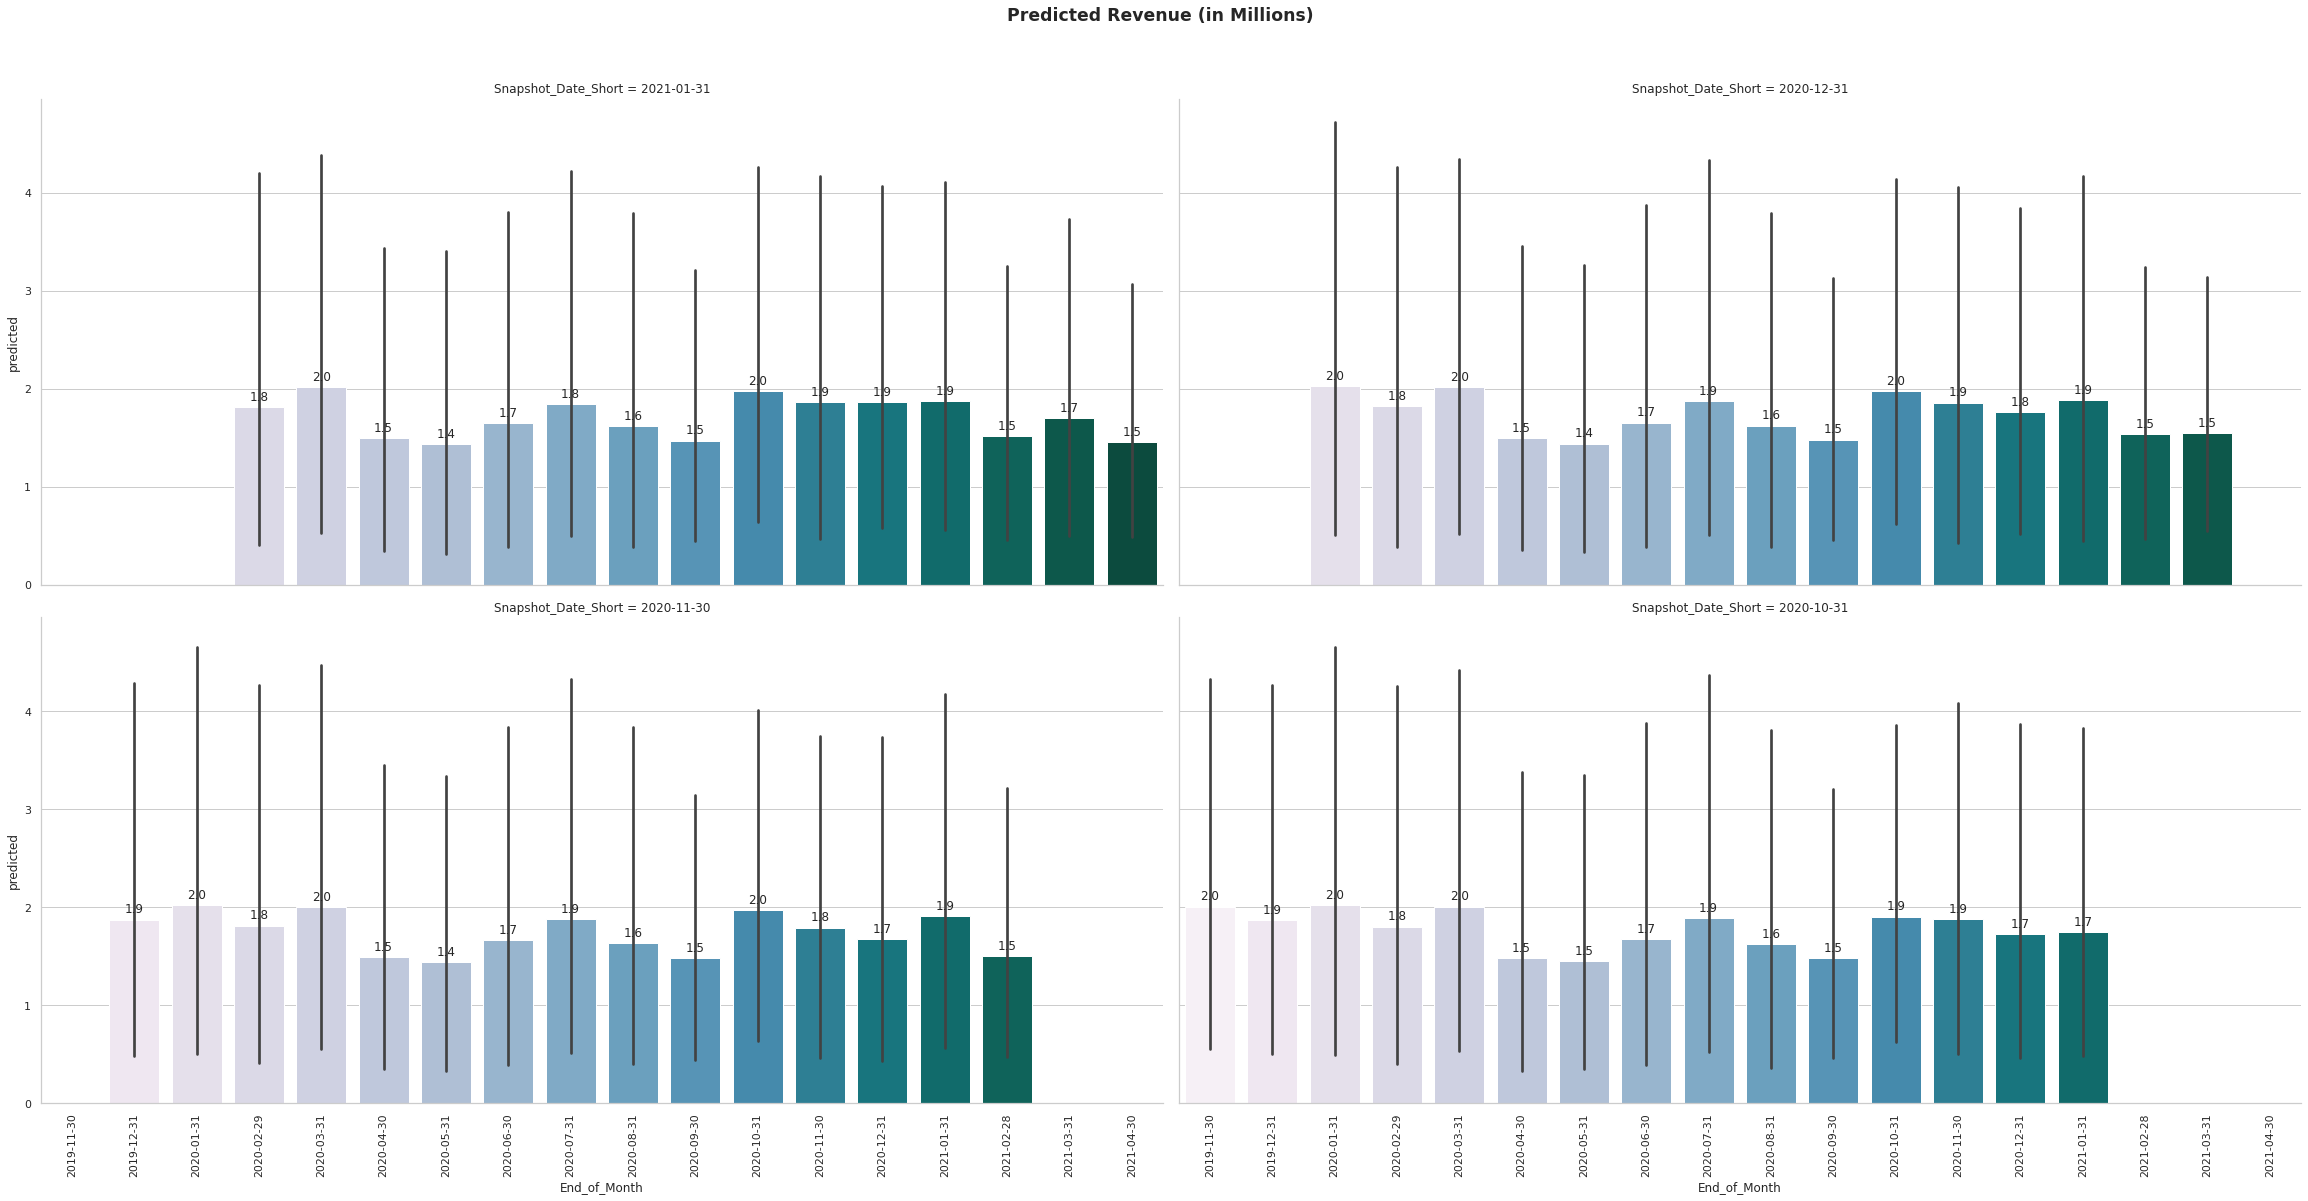

In [114]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Revenue (in Millions) ', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

catplot is a figure-level function and does not accept target axes. You may wish to try barplot


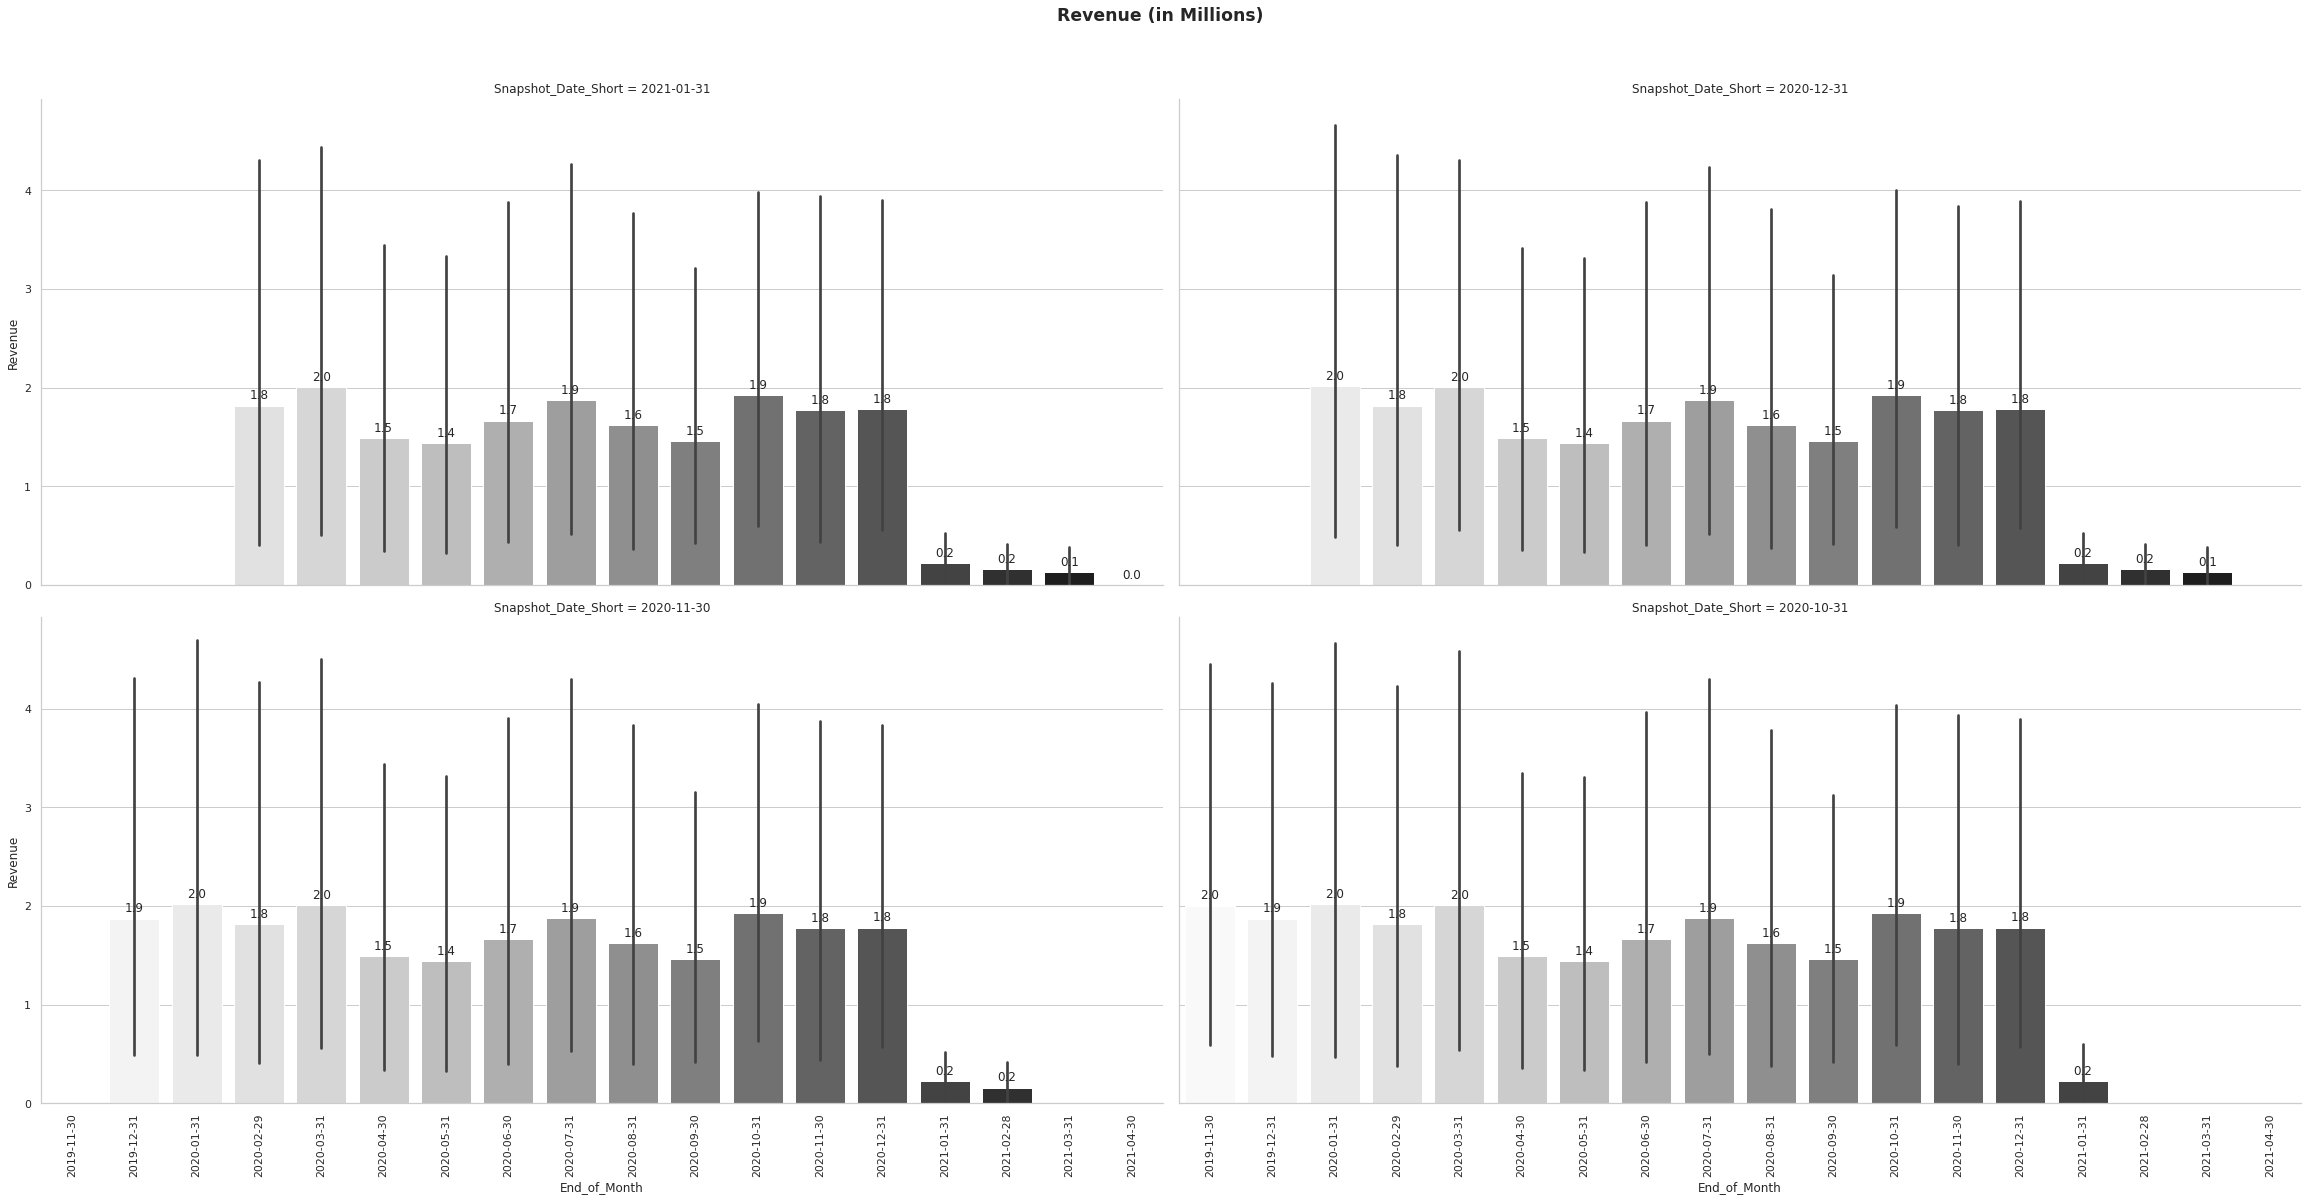

In [115]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Revenue',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='Greys',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue (in Millions) ', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

catplot is a figure-level function and does not accept target axes. You may wish to try barplot


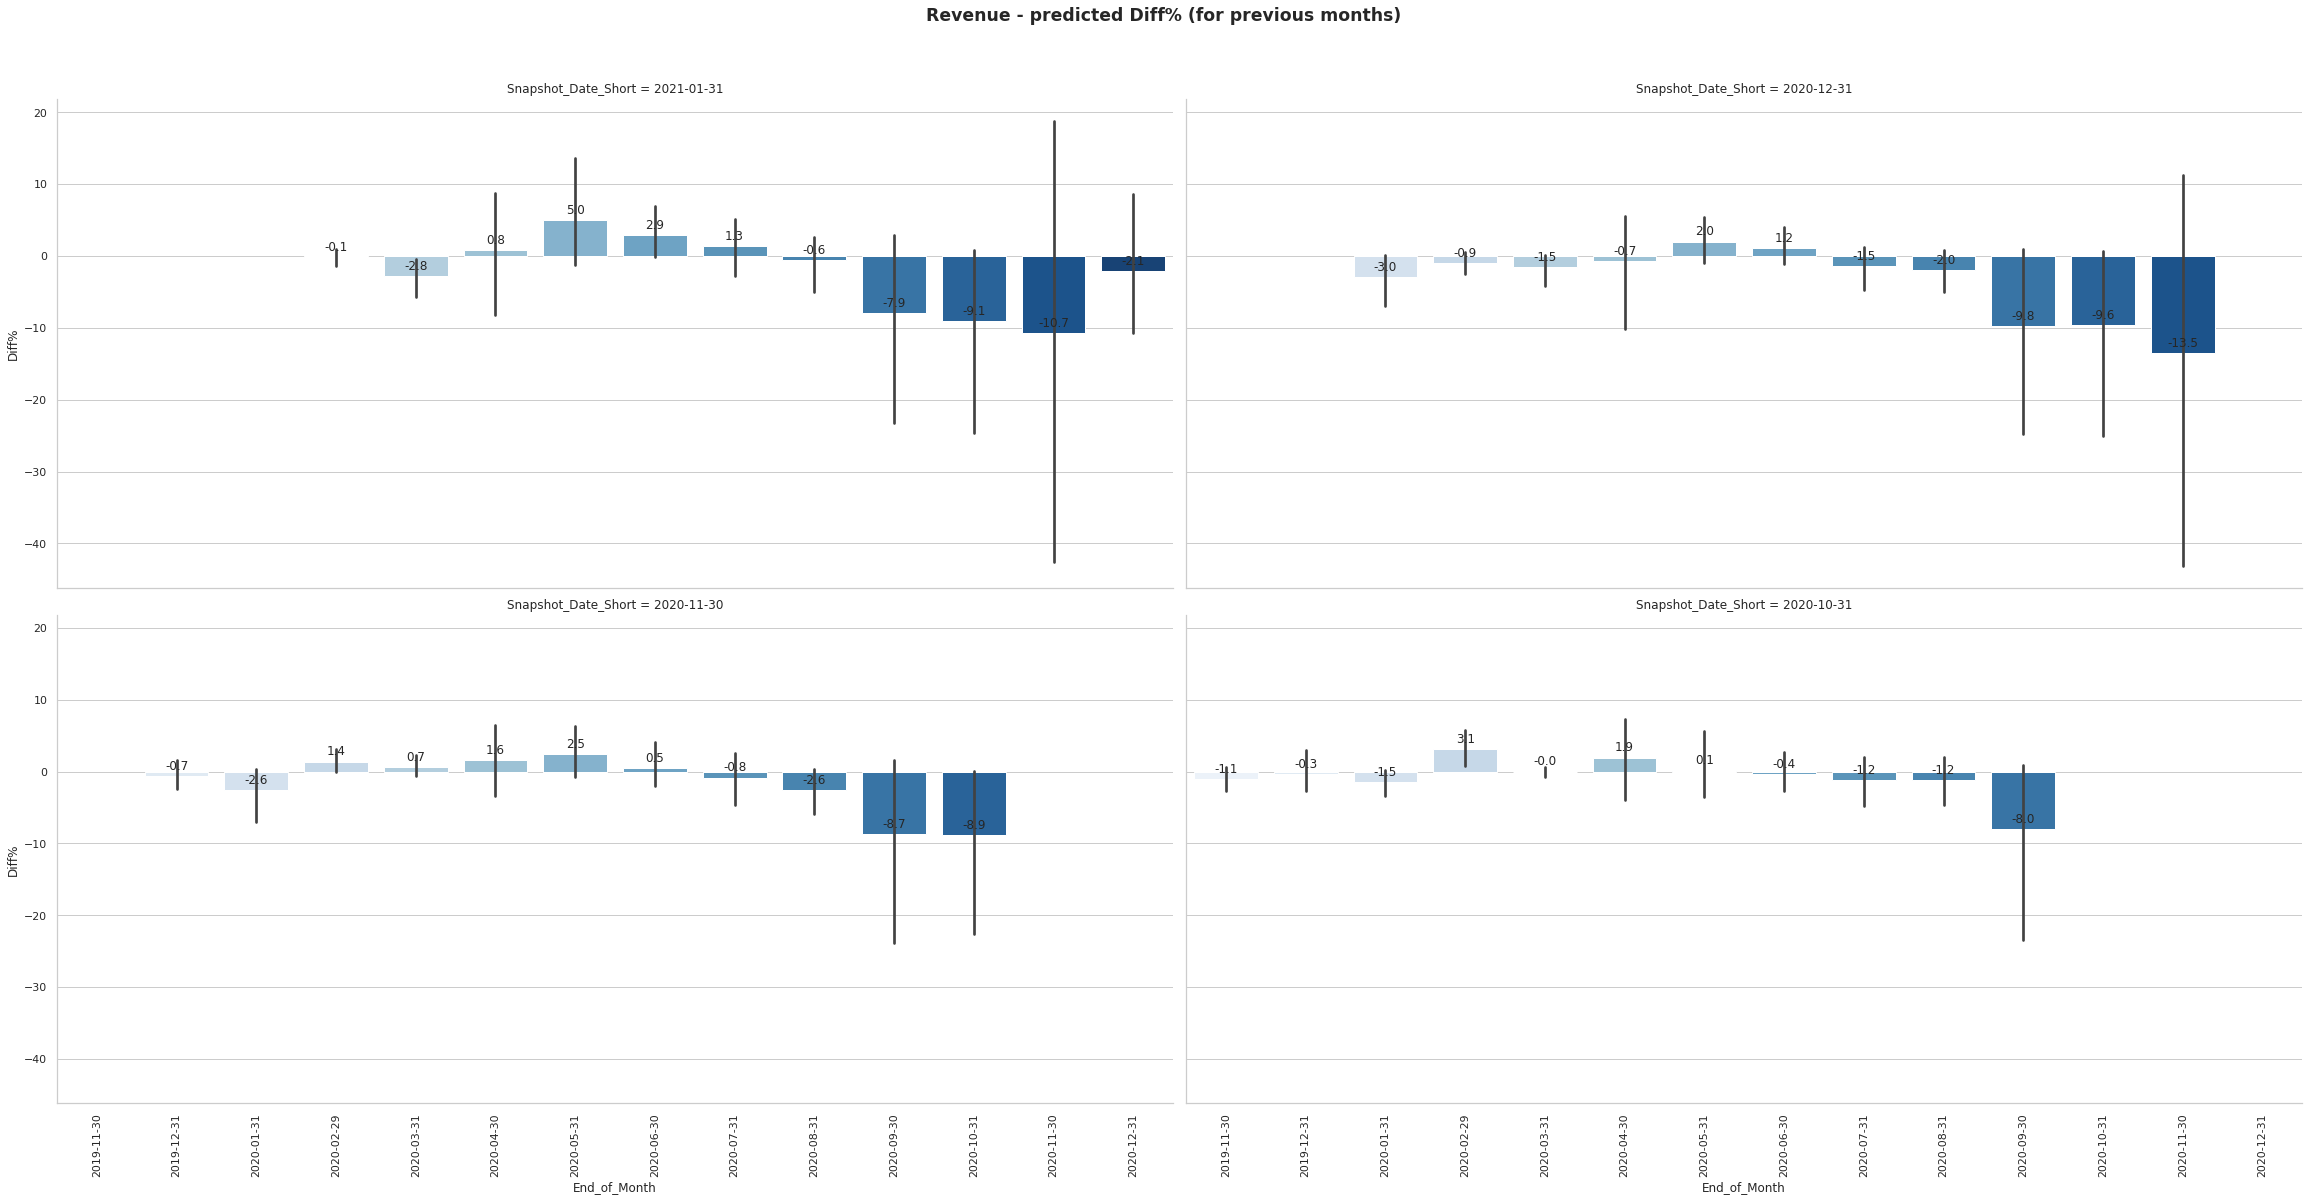

In [116]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset < 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Diff%',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='Blues',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue - predicted Diff% (for previous months)', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

catplot is a figure-level function and does not accept target axes. You may wish to try barplot


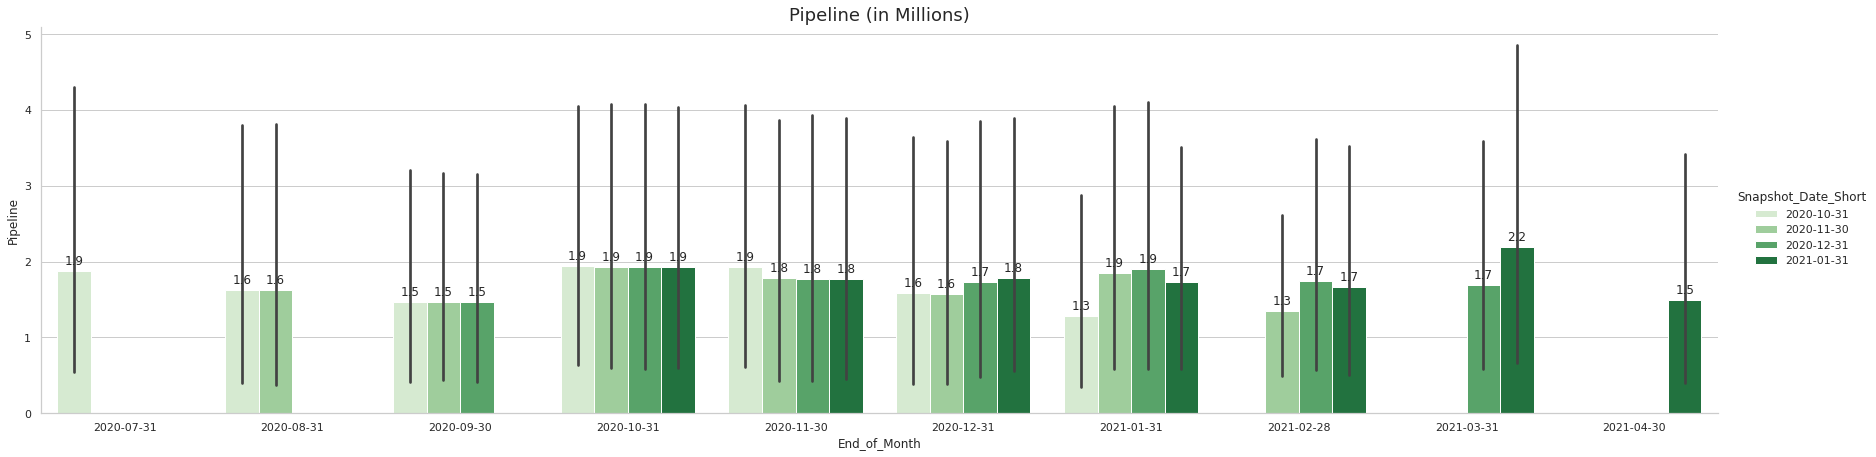

In [117]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Pipeline',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='Greens',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Pipeline (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

catplot is a figure-level function and does not accept target axes. You may wish to try barplot


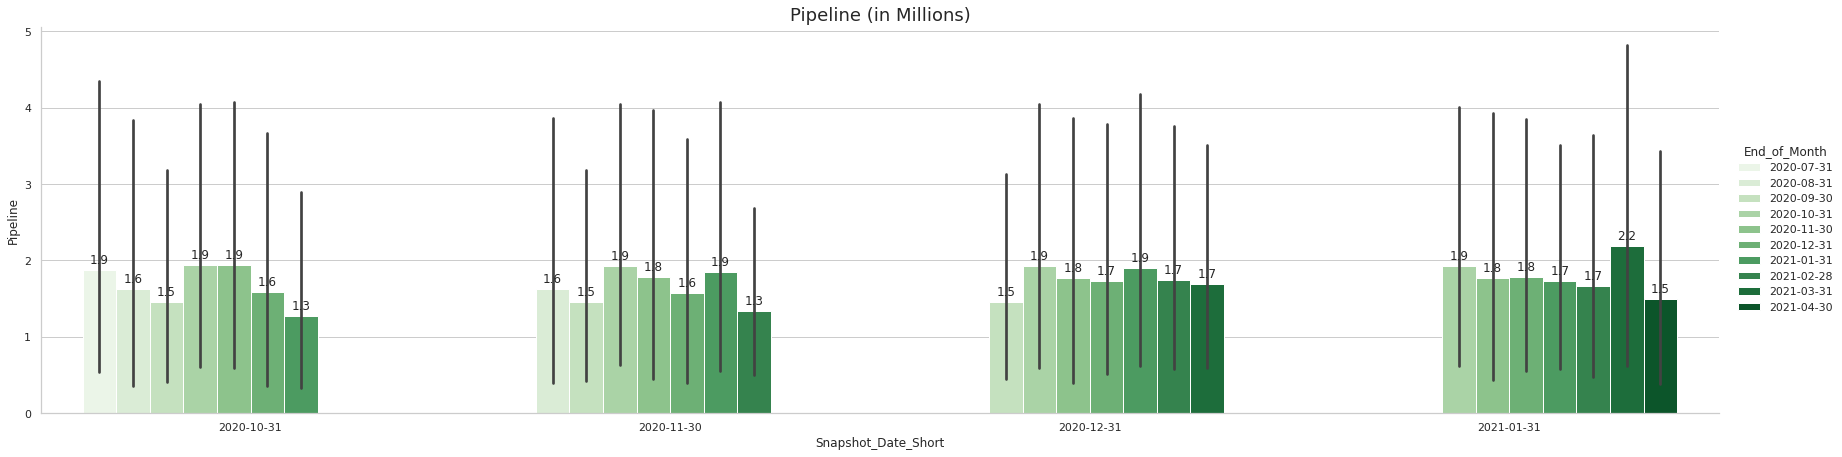

In [118]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='Snapshot_Date_Short',
    y='Pipeline',
    hue='End_of_Month',
    kind='bar',
    palette='Greens',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Pipeline (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

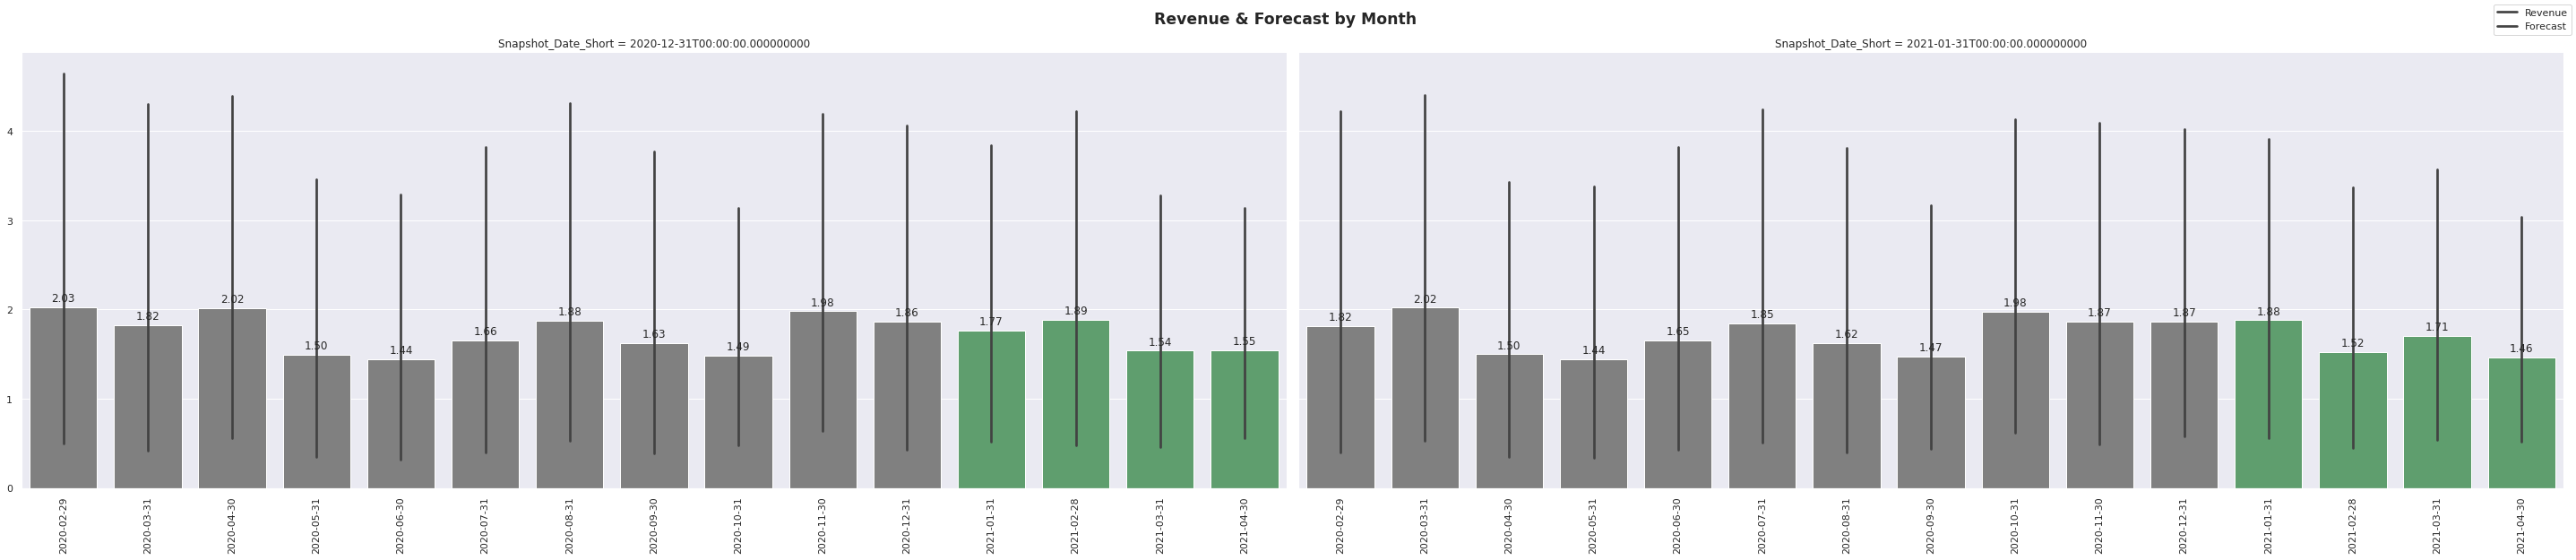

In [119]:
sns.set()
div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -1').copy()
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]
g = sns.FacetGrid(data=final_merge_df1, col='Snapshot_Date_Short',
                  height=8, aspect=2.5, col_wrap=2,
                  palette=clrs) #alpha=0.50

g.map_dataframe(sns.barplot, x='End_of_Month', y='Revenue_Forecast',
                palette=clrs)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.2f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue & Forecast by Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()


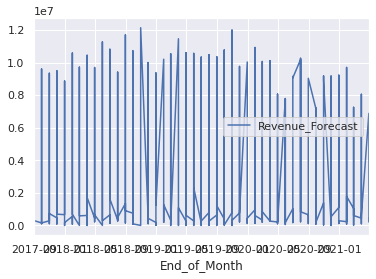

In [120]:
final_merge_df.plot(x='End_of_Month', y='Revenue_Forecast')

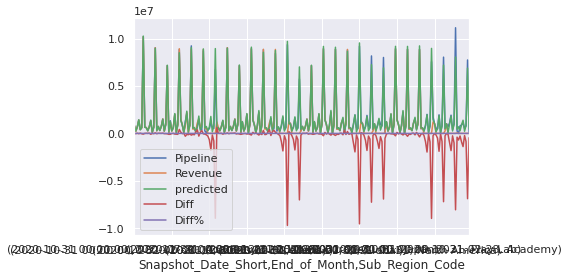

In [121]:
final_merge_pivot1.plot()

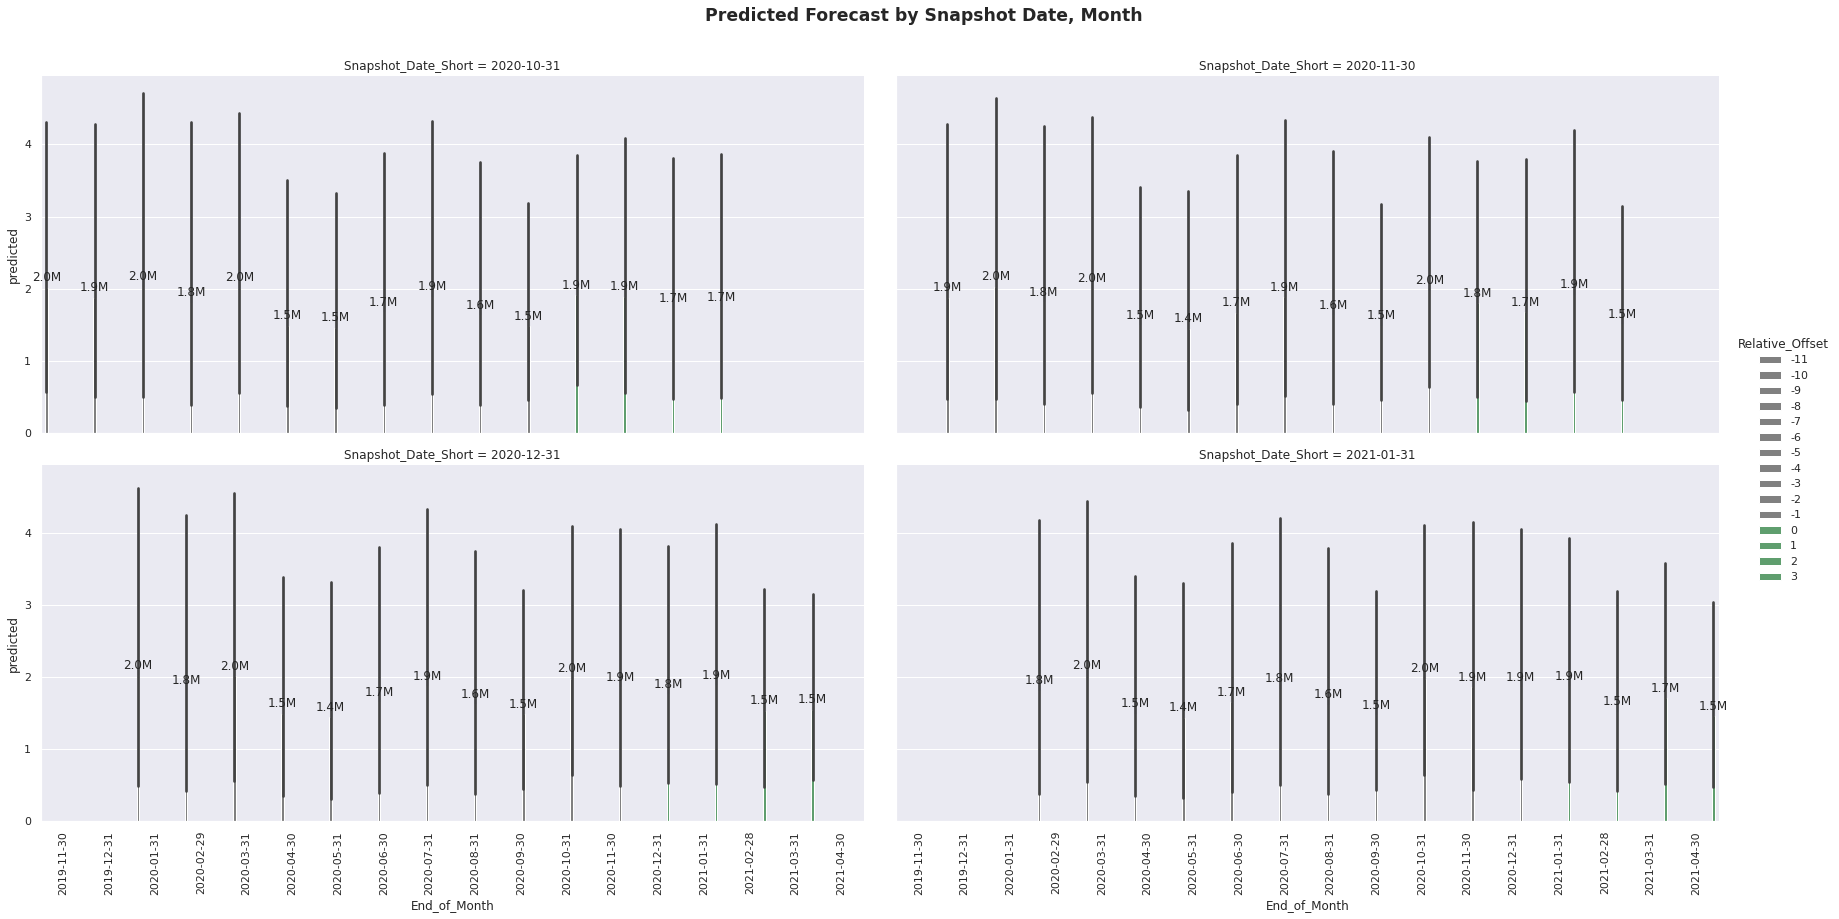

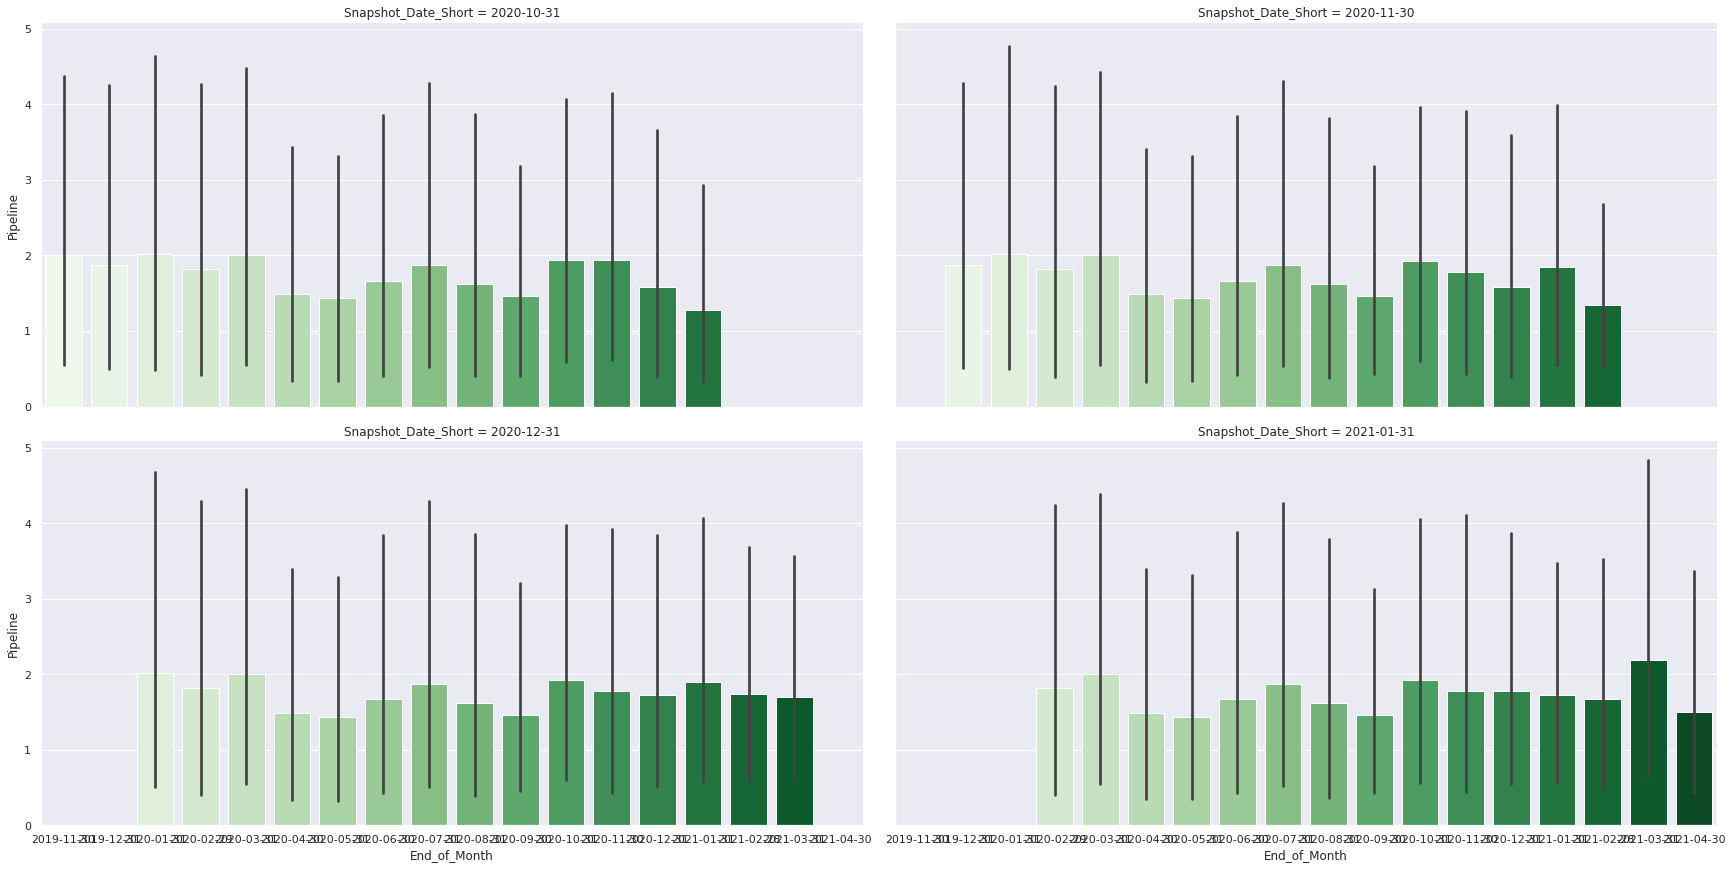

In [122]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)
final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)
values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  # alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette=clrs
    )

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g1 = sns.catplot(x='End_of_Month', y='Pipeline', 
    data=final_merge_df2,
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='Greens' )

g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

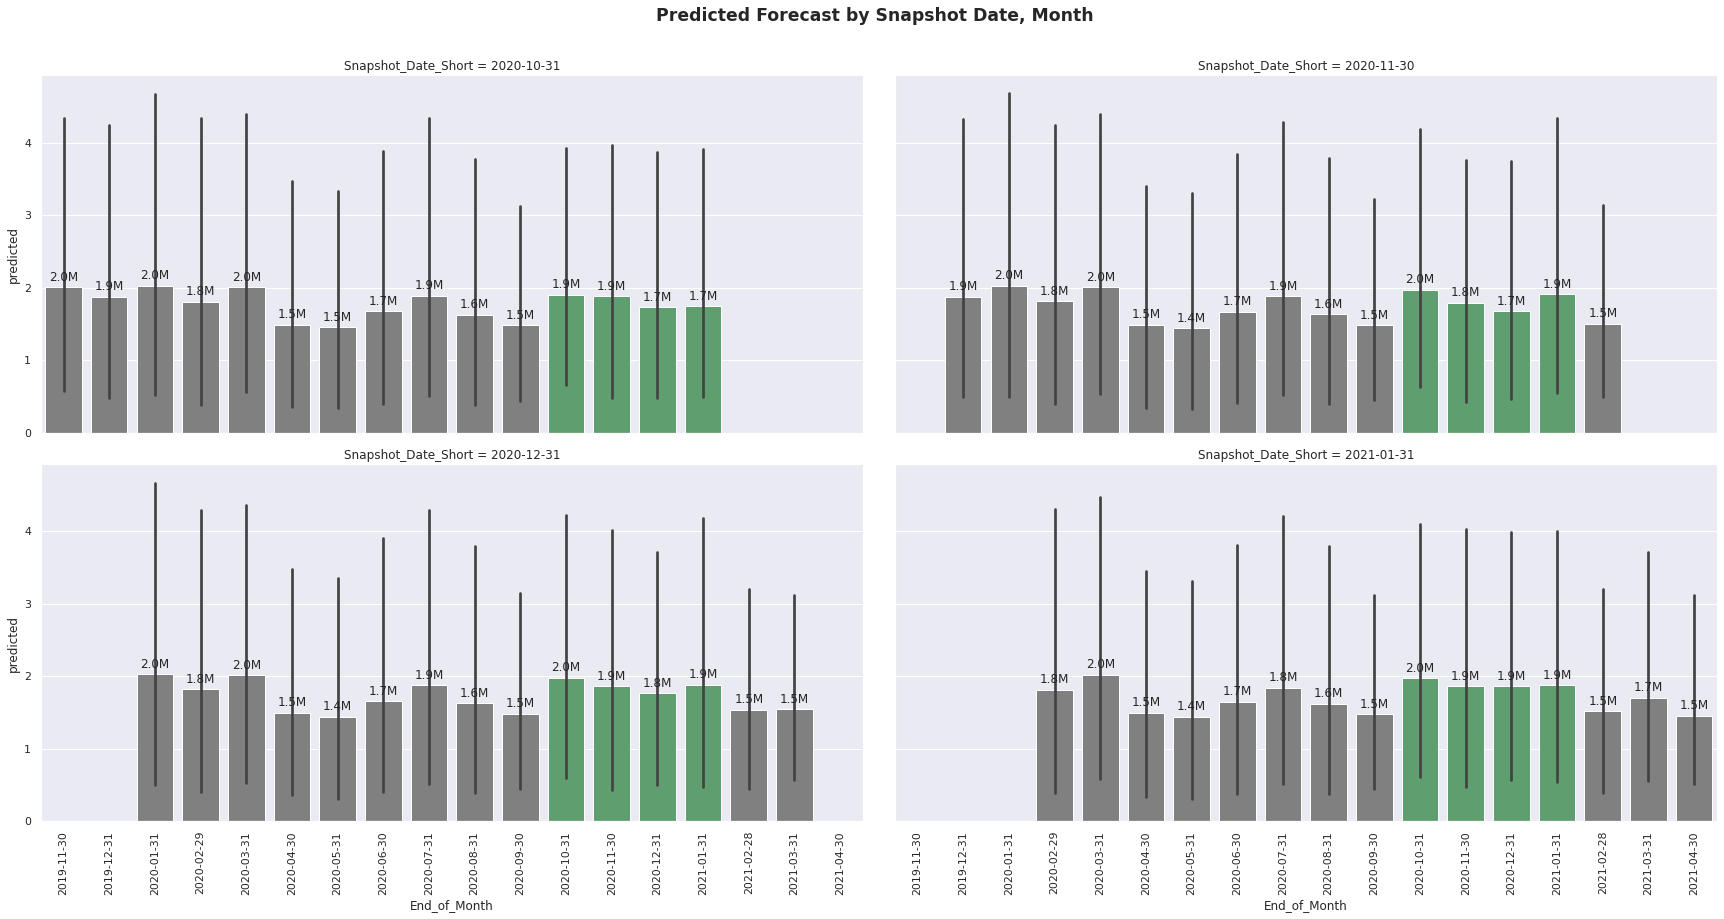

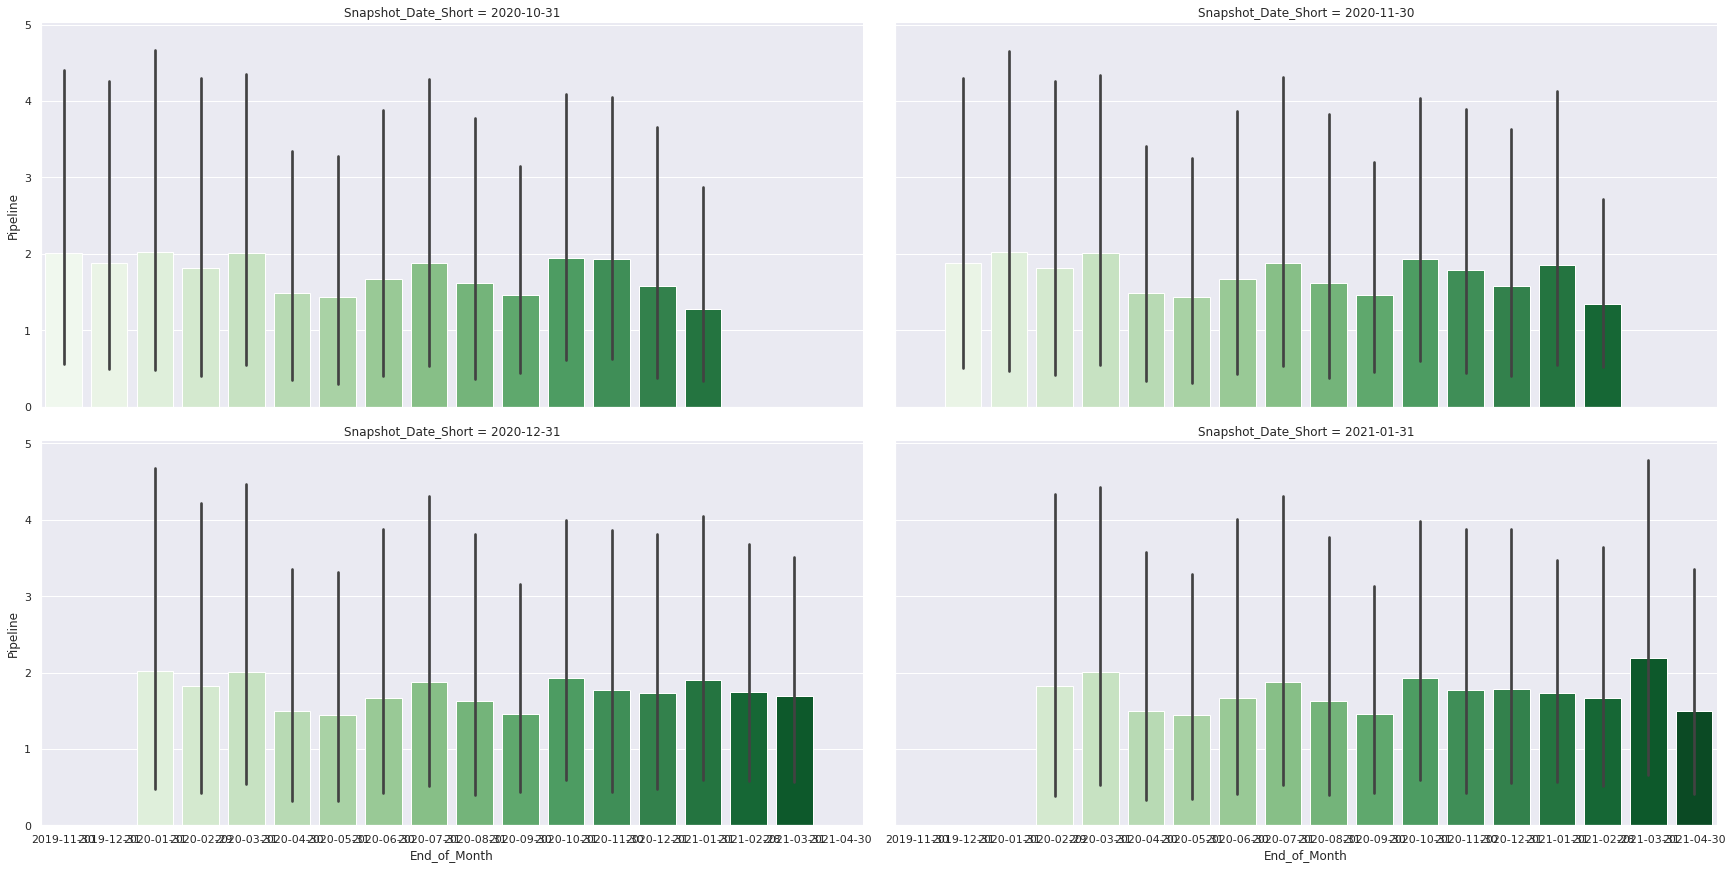

In [123]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)
final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)
values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  # alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    #hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette=clrs
    )

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g1 = sns.catplot(x='End_of_Month', y='Pipeline', 
    data=final_merge_df2,
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='Greens' )

g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

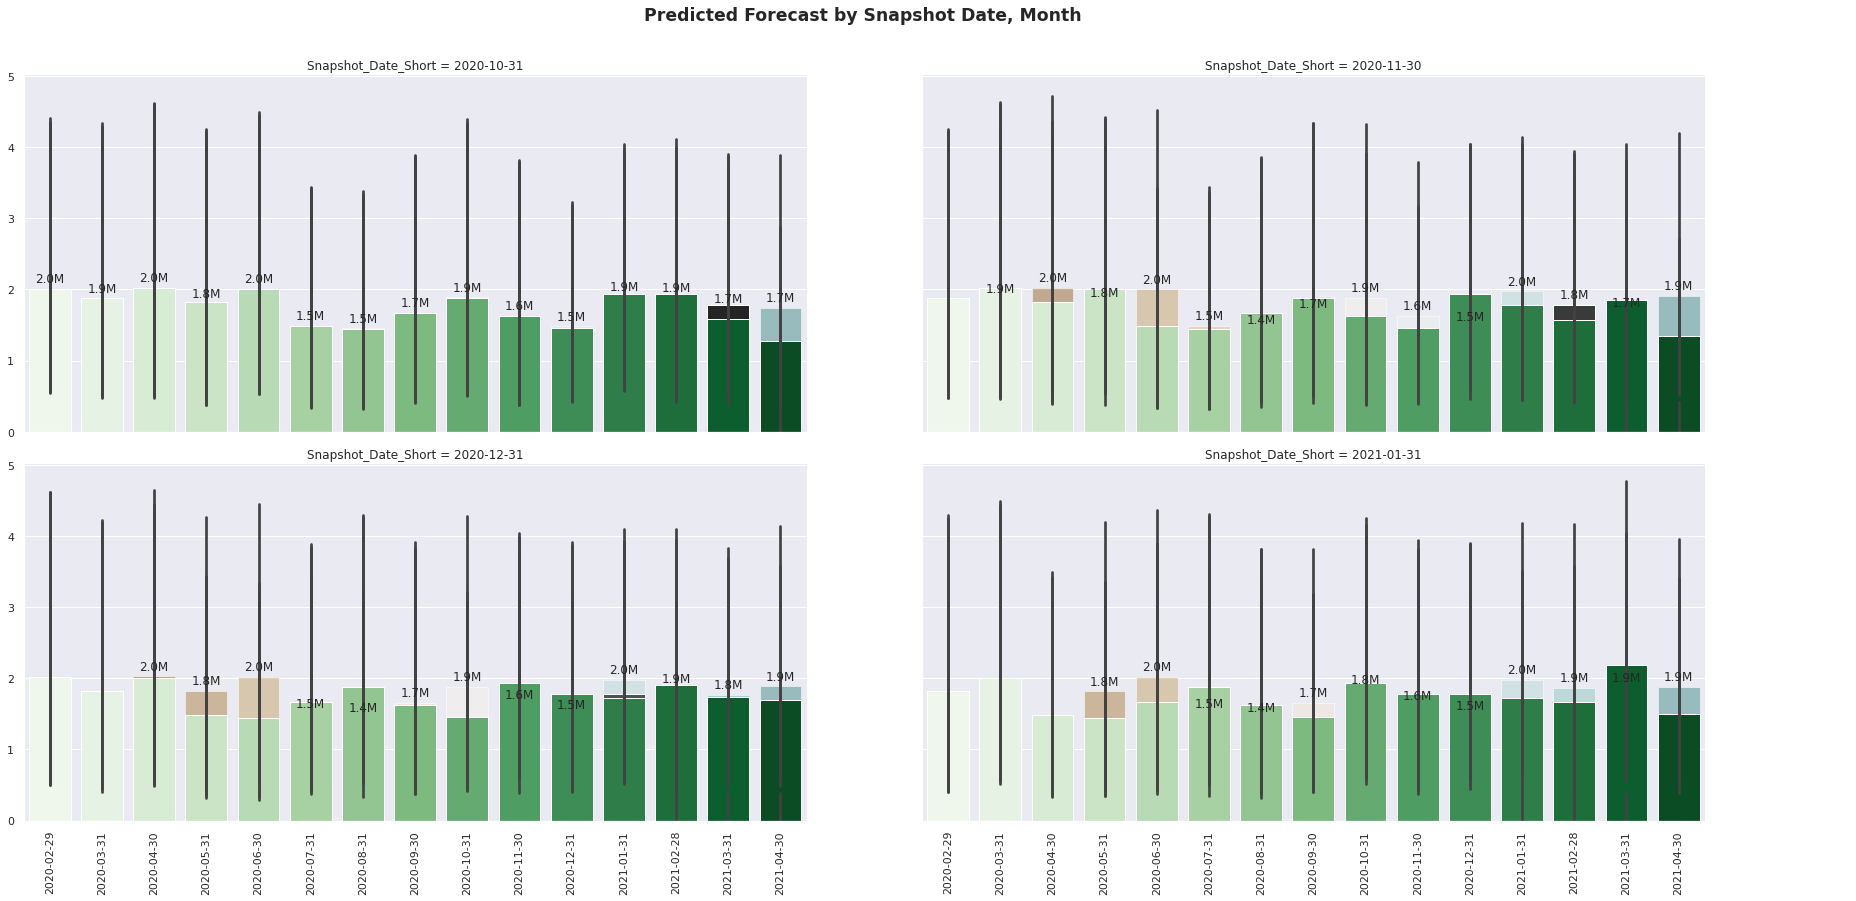

In [124]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)

final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Revenue'] = \
    round(final_merge_df2['Revenue'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)

values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    #hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='BrBG'
    )
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.map_dataframe(sns.barplot, x='End_of_Month', y='Revenue', color = '.5',
                palette='Greys')
g.map_dataframe(sns.barplot, x='End_of_Month', y='Pipeline', color = '.5',
                palette='Greens')
g.add_legend()
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend()
plt.show()

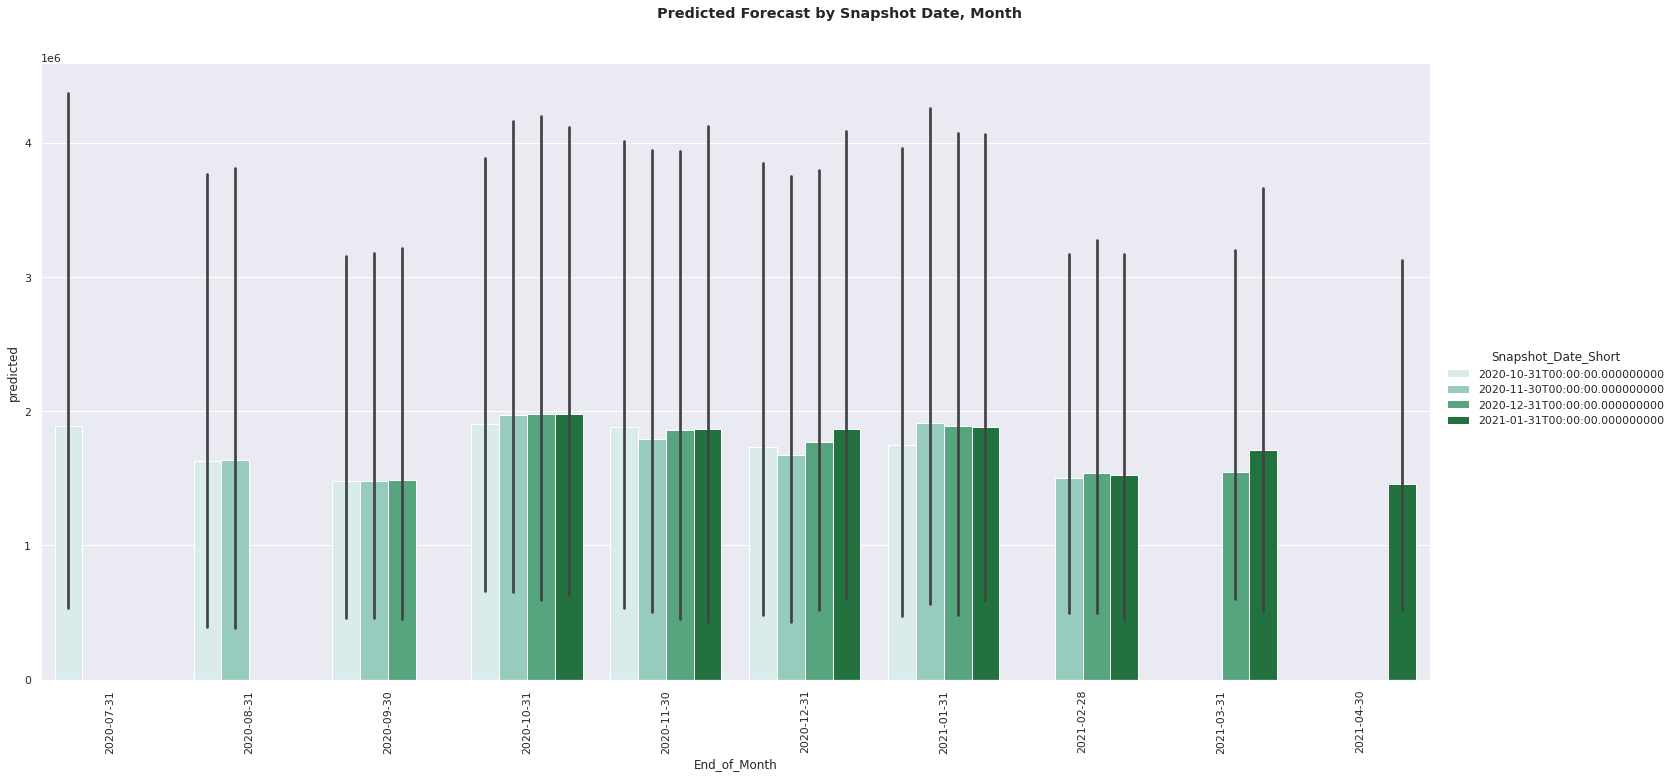

In [125]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
sns.set()
dfx = final_merge_pivot1.reset_index(inplace=False).copy()
g = sns.catplot(
    data=dfx,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='BuGn',
    height=10,
    aspect=2
    )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month',
               fontsize='large', fontweight='bold')
g.fig.subplots_adjust(top=0.90)
g


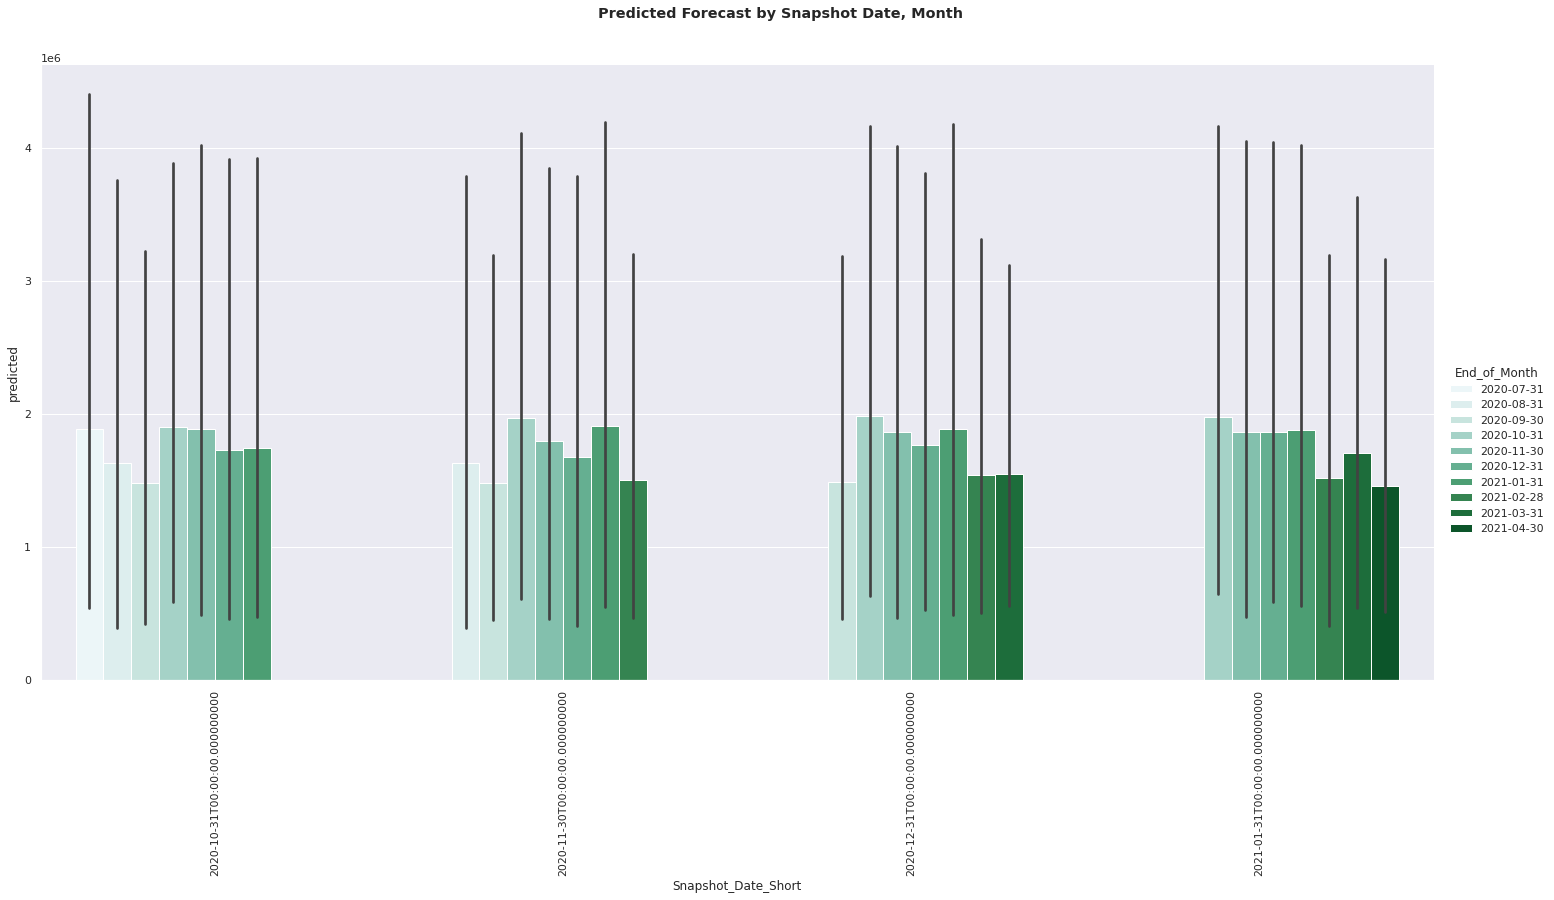

In [126]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
sns.set()
dfx = final_merge_pivot1.reset_index(inplace=False).copy()
g = sns.catplot(
    data=dfx,
    x='Snapshot_Date_Short',
    y='predicted',
    hue='End_of_Month',
    kind='bar',
    palette='BuGn',
    height=10,
    aspect=2
    )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month',
               fontsize='large', fontweight='bold')
g.fig.subplots_adjust(top=0.90)
g


In [ ]:
STOP*************************************************************

In [ ]:
Operationalize
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

In [ ]:
#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

In [ ]:
#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': 'automl-forecasting'},
                                               description = 'Automl forecasting revenue service')

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

In [ ]:
aci_service.get_logs()

In [ ]:
#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [ ]:
y_fcst_all.head()

In [ ]:
#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally

In [ ]:
STOP

In [ ]:
#Export revenue only for time series forecast
#cols = revhist1.columns
#revtime_hist = merge_df[cols].query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist = merge_final.query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist.to_csv('revtime_hist.csv', index=False)
#revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
#revtime_foreast.drop(columns=['Revenue'], axis=1, inplace = True)
#revtime_foreast.to_csv('revtime_foreast.csv', index=False)

In [ ]:
#Plot dataset
sns.set()
sns.set_context('talk') #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style='whitegrid') #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette('Accent',8)
# Use palplot and pass in the variable:
sns.palplot(palette)
# Set the palette using the name of a palette:
sns.set_palette(palette)

dataset = revtime_hist
dataset['End_of_Month'] = pd.to_datetime(dataset['End_of_Month'])
dataset = dataset.set_index('End_of_Month')
values = dataset.values
# specify columns to plot
groups = [0,1] #, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.1, loc='right')
    i += 1
plt.show()

In [ ]:
dataset['Revenue'].plot()